# Numerical Estimate Analysis Pipeline

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import copy
import datetime

## Load in data if pipeline has already been run through: 

In [2]:
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis'

raw_dir = _dir + '/data/finalVEMatched/raw'
zs_dir = _dir + '/data/finalVEMatched/z_scored'

final_data = pd.read_csv (raw_dir + '/raw_data.csv')
zscored_data = pd.read_csv (zs_dir + '/z_scored_data.csv')

In [3]:
num_trials = 156

## Data Cleaning

In [9]:
def combineCSVs(datafolder):
    """
    Args:
        datafolder = path to data 
    Returns:
        df of all participant data 
        OR
        df for singlle participant
    """
        
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    '''
    Args: 
        datafolder = path to data  
        
    returns:
        df with all estimates converted to meters      
    '''
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m

    
    return input_data

def cleanAgeResponses(datafolder):
    '''
    Args: 
        datafolder = path to data  
        
    returns:
        df with cleaned reported age 
    '''
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        today = datetime.date.today()
        year = today.year
        if age > 2000:
            actual_age = year-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
            print(row['subjID'])
            print(actual_age, age)


    return input_data    

def catchTrial_cleaning(path, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 6/8 catch trials are correct, the participant is excluded.  
    
    Args: 
        path = path to data  
        correct_requirement = accuracy threshold (6 correct trials - pre-registered)
        catch_stimuli = list of stimuli that are used in catch trials (no target in the image)        
        
    returns:
        df (participants with less than 6/8 trials correct removed)  
    '''
    
    df = cleanAgeResponses(path)
    
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        count_correct = 0
        for idx, row in subj_df.iterrows():
            stim = row['stimulus']
            if type(stim) == str:
                if stim.split('/')[1] in catch_stimuli:
                    if row["depth_estimate"] == 0:
                        count_correct += 1

                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)

        if count_correct < correct_requirement:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
            
    for subj in remove:
        df2.drop(df2[df2['subjID'] == subj].index, inplace = True) 
    
    return df2
    

def removeMissedTrials(input_data, num_trials):
    """
    Participants were told that if they missed a trial, to respond '0'.
    
    Args: 
        input_data = catch trial cleaned data 
        num_trials = total number of trials in the experiment
        
    returns:
        df (participants with more than 10% of their data missing were removed) 
    """
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']

        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
                    
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(num_trials * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))
            
    for subj in remove_ids:
        input_data.drop(input_data[input_data['subjID'] == subj].index, inplace = True) 

    # Note if a particular participant, duration, or sequence has many missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [49]:
path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/data'



In [50]:
sequences_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_duration_MTurk/jsons'

sequences_count_dict = {}
for seq in os.listdir(sequences_path):
    if 'json' in seq:
        sequences_count_dict['jsons/'+seq] = 0


In [51]:

all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [52]:
catch_trial_cleaned_data = catchTrial_cleaning(path, 6, all_catch_stim)

Number of participants before cleaning:  1116
Number of participants that did not pass the catch trial check: 366


In [53]:
missed_trial_cleaned_data = removeMissedTrials(catch_trial_cleaned_data, num_trials)

Number of participants with 10% or more missed trials:  101


## Distribution of Unit Preferences

In [54]:
pre_unitconversion_data = combineCSVs(path)

Number of participants before cleaning:  1116


In [55]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit[0] == "feet":
        feet_count += 1
    if unit[0] == "meters":
        meters_count += 1
    
meters_count, feet_count

(470, 646)

In [56]:
def RT_Cleaning(df, outlier_range, num_trials):
    '''
    Trials with a response time lower than 250 ms or greater than 10 seconds were excluded. 
    If more than 10% of trials were excluded on this basis, the participant was excluded
    
    Args: 
        df = missed trial cleaned data 
        outlier_range = pre-registered response time outlier range [250ms, 10s]
        num_trials = total number of trials in the experiment
        
    returns:
        df (participants with more than 10% of their trials removed are excluded) 
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
            
    for subj in remove:
        df2.drop(df2[df2['subjID'] == subj].index, inplace = True) 
                
    return df2

In [57]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data, [250, 10000], num_trials)

Number of Participants with 10% or more trials outside their RT range:  75


In [58]:
def repeatResponses_Cleaning(df):
    """
    Some participants submitted ‘junk data’ by repeating the same distance estimate for every trial. 
    The frequency of unique responses entered by the participant was counted to catch these instances. 
    If participants entered fewer than six unique responses they were excluded.
    
    Across all participants the maximum number of repeats was averaged. 
    The outlier parameter range for maximum repeats was then calculated as: Avg-3SD, Avg+3SD. 
    After these steps, if a participant was missing at least 10% of their data, they were excluded.
    
    Args: 
        df = RT cleaned data 
        
    returns:
        df (participants were excluded by the criterion described above) 
    
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
            
    print('Number of participants with less than 6 unique responses:', len(remove))
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
                print(True)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                print(True)

    print("Total number of participants removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 

    
    return df, max_repeats_distribution, num_unique_responses_distribution



In [59]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(RT_cleaned_data)

Number of participants with less than 6 unique responses: 84
Total number of participants removed:  84


In [60]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    
    Args: 
        df = repeat responses cleaned data 
        num_trials = total number of trials in the experiment
        
    returns:
        df (participants with more than 10% of their trials removed are excluded) 
    """
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))

    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [61]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data, num_trials)

Number of Participants with >= 10% trials removed:  22
Number of participants left:  468


In [62]:
len(cleaned_data.sequenceName.unique())

468

In [63]:
final_data = cleaned_data.copy(deep=True)

In [10]:
len(final_data.subjID.unique())

468

### Z-Score Depth Estimates and RT 

In [11]:
def zscored_outcomes(df):
    '''
    Args:
        final df
    returns:
        z-score depth estimates and RTs and replace values in the existing df
            --> for each subj calculate their avg and std 
            --> zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score depth estimates
        average_estim = subj_df["depth_estimate"].mean()
        std_estim = subj_df["depth_estimate"].std()
        subj_depth_estimates = np.array(list(subj_df["depth_estimate"]))
        zscored_subj_depth_estimates = (subj_depth_estimates - average_estim)/std_estim
        final_subj_df.replace(subj_depth_estimates, zscored_subj_depth_estimates, inplace=True)
        # Z-Score RT
        average_RT = subj_df["trial_RT"].mean()
        std_RT = subj_df["trial_RT"].std()
        subj_RTs = np.array(list(subj_df["trial_RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.replace(subj_RTs, zscored_subj_RTs, inplace=True)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2
     

In [5]:
zscored_data = zscored_outcomes(final_data)

# If data was pre-loaded in, START HERE

### Average estimate:

In [4]:
average_depth_estimate = final_data['depth_estimate'].mean()
average_depth_estimate

3.6279030201882794

# Subject Results

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

def subject_pivotTable(data, duration):
    """
    Args:
        data = subject df at a particular duration after cleaning and outlier removal
        duration = 125, 250, or 1000ms
    returns:
        subject pivot table
        Organizes data such that for each rounded actual depth the following is calulated:
        - average depth estimation
        - standard deviation
        - standard error 
    """

    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized by N-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Args:
        data = subject pivot table at a particular duration
    returns:
        data in lists 
        x = actual depth values
        y = average estimated depth
        ste = standard error 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 


def RT_subject_pivotTable(data, duration):
    """
    Args:
        data = subject df at a particular duration after cleaning and outlier removal
        duration = 125, 250, or 1000ms
    returns:
        subject pivot table for RT data
        Organizes data such that for each rounded actual depth the following is calulated:
        - average RT
        - standard deviation
        - standard error  
    """

    avg = pd.pivot_table(data,  values = ["trial_RT"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'trial_RT': 'Average RT'})
        
    std = pd.pivot_table(data, values = ["trial_RT"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'trial_RT': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["trial_RT"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'trial_RT': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def RT_subject_getxy(data):
    """
    Args:
        data = subject pivot table at a particular duration for RT data
    returns:
        data in list format for plotting
        x = actual depth values
        y = average estimated depth
        ste = standard error 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average RT"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 


In [13]:
def AnovaRM_subjectData(df, duration):
    """
    Args:
        df = dataframe for a particular duration 
        duration = 125, 250, or 1000ms
    returns:
        slope_df = dictionary that includes subjID, duration, slope (m from linear regression of estimated depth x actual depth), and age
        intercept_df = dictionary that includes subjID, duration, intercept (b from linear regression of estimated depth x actual depth), and age 
    
    """
    
    all_subjIDs = df.subjID.unique()
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        duration_subj_df = subj_df
        duration_subj_pivot = subject_pivotTable(duration_subj_df, duration)
        duration_subj_data = subject_getxy(duration_subj_pivot)

        x = np.array(duration_subj_data[0])
        y = np.array(duration_subj_data[1])
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        subj_slopes['subjID'].append(subj)
        subj_slopes['duration'].append(duration)
        subj_slopes['slope'].append(slope)
        subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
        subj_intercepts['subjID'].append(subj)
        subj_intercepts['duration'].append(duration)            
        subj_intercepts['intercept'].append(intercept)
        subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df


def RT_AnovaRM_subjectData(df, duration):
    """
    Args:
        df = dataframe for a particular duration 
        duration = 125, 250, or 1000ms
    returns:
        slope_df = dictionary that includes subjID, duration, slope (m from linear regression of RT x actual depth), and age
        intercept_df = dictionary that includes subjID, duration, intercept (b from linear regression of RT x actual depth), and age 
    """
    
    all_subjIDs = df.subjID.unique()
    subj_slopes = {'subjID': [], 'duration': [], 'slope': [], 'age': []}
    subj_intercepts = {'subjID': [], 'duration': [], 'intercept' : [], 'age': []}

    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 

        duration_subj_df = subj_df
        duration_subj_pivot = RT_subject_pivotTable(duration_subj_df, duration)
        duration_subj_data = RT_subject_getxy(duration_subj_pivot)

        x = np.array(duration_subj_data[0])
        y = np.array(duration_subj_data[1])
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        subj_slopes['subjID'].append(subj)
        subj_slopes['duration'].append(duration)
        subj_slopes['slope'].append(slope)
        subj_slopes['age'].append(duration_subj_df.age.unique()[0])
            
        subj_intercepts['subjID'].append(subj)
        subj_intercepts['duration'].append(duration)            
        subj_intercepts['intercept'].append(intercept)
        subj_intercepts['age'].append(duration_subj_df.age.unique()[0])
                
    slope_df = pd.DataFrame(data=subj_slopes)
    intercept_df = pd.DataFrame(data=subj_intercepts)
        
    return slope_df, intercept_df

### Filter data by duration

In [17]:
zs_final_data_125 = zscored_data.loc[zscored_data["duration"]  == 125]
zs_final_data_250 = zscored_data.loc[zscored_data["duration"]  == 250]
zs_final_data_1000 = zscored_data.loc[zscored_data["duration"]  == 1000]

zscored_duration_data = [zs_final_data_125, zs_final_data_250, zs_final_data_1000]


In [11]:
final_data_125 = final_data.loc[final_data["duration"]  == 125]
final_data_250 = final_data.loc[final_data["duration"]  == 250]
final_data_1000 = final_data.loc[final_data["duration"]  == 1000]

# Analyze data by subject

In [14]:
slopes_125, df_intercept_125 = AnovaRM_subjectData(zs_final_data_125, 125)
slopes_250, df_intercept_250 = AnovaRM_subjectData(zs_final_data_250, 250)
slopes_1000, df_intercept_1000 = AnovaRM_subjectData(zs_final_data_1000, 1000)

In [15]:
RT_slopes_125, RT_df_intercept_125 = RT_AnovaRM_subjectData(zs_final_data_125, 125)
RT_slopes_250, RT_df_intercept_250 = RT_AnovaRM_subjectData(zs_final_data_250, 250)
RT_slopes_1000, RT_df_intercept_1000 = RT_AnovaRM_subjectData(zs_final_data_1000, 1000)

In [16]:
raw_slopes_125, raw_df_intercept_125 = AnovaRM_subjectData(final_data_125, 125)
raw_slopes_250, raw_df_intercept_250 = AnovaRM_subjectData(final_data_250, 250)
raw_slopes_1000, raw_df_intercept_1000 = AnovaRM_subjectData(final_data_1000, 1000)

### Calculate average participant slope per duration

In [53]:
zs_avg_slope_125 = np.mean(np.array(slopes_125['slope']))
zs_ste_slope_125 = stats.sem(np.array(slopes_125['slope']))

zs_avg_slope_250 = np.mean(np.array(slopes_250['slope']))
zs_ste_slope_250 = stats.sem(np.array(slopes_250['slope']))

zs_avg_slope_1000 = np.mean(np.array(slopes_1000['slope']))
zs_ste_slope_1000 = stats.sem(np.array(slopes_1000['slope']))

In [54]:
# Total number of participants = 468
len(slopes_125['slope']) + len(slopes_250['slope']) + len(slopes_1000['slope'])

468

In [55]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_250['slope'], slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_250['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['slope'], slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_250['slope'], slopes_1000['slope'])
print(fvalue, pvalue)

2.1410791299573053 0.11868519608957244
1.8212466318005085 0.17814966938513652
4.480814512674913 0.03507379792855162
0.4810698815233704 0.4884574662415514


In [58]:
all_slopes = pd.concat([slopes_125, slopes_250, slopes_1000])


In [57]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('slope ~ C(duration)', data=all_slopes).fit()
# model = ols('slope ~ C(duration) + C(age) + C(duration):C(age)', data=all_slopes).fit()

aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(duration),0.231334,2.0,2.141079,0.118685
Residual,25.120600,465.0,NaN,NaN


In [74]:
RT_zs_avg_slope_125 = np.mean(np.array(RT_slopes_125['slope']))
RT_zs_ste_slope_125 = stats.sem(np.array(RT_slopes_125['slope']))

RT_zs_avg_slope_250 = np.mean(np.array(RT_slopes_250['slope']))
RT_zs_ste_slope_250 = stats.sem(np.array(RT_slopes_250['slope']))

RT_zs_avg_slope_1000 = np.mean(np.array(RT_slopes_1000['slope']))
RT_zs_ste_slope_1000 = stats.sem(np.array(RT_slopes_1000['slope']))

In [75]:
len(RT_slopes_125['slope']) + len(RT_slopes_250['slope']) + len(RT_slopes_1000['slope'])

468

In [76]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(RT_slopes_125['slope'], RT_slopes_250['slope'], RT_slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(RT_slopes_125['slope'], RT_slopes_250['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(RT_slopes_125['slope'], RT_slopes_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(RT_slopes_250['slope'], RT_slopes_1000['slope'])
print(fvalue, pvalue)

1.4001619916506935 0.2475945343742338
2.8191994857725793 0.09415044058262302
0.3444770354712643 0.5576835040124881
1.0973028337746034 0.2956748116215269


### Raw results 

In [99]:
def subject_pivotTable(data, duration):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    avg = pd.pivot_table(data,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
    std = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
        
    #Label the data by duration 
    result["Duration"] = duration
    
    return result

def subject_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    """
    x = []
    y = []
    ste = []
    for idx, row in data.iterrows():
        x.append(idx) #idx is the actual depth value 
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
   
    return x, y, ste 

def subjectData(df):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    
    all_subjIDs = df.subjID.unique()
    
    subj_slopes_intercepts = {'subjID': [], 'duration': [], 'slope': [], 'intercept' : [], 'age': [], 'gender': []}
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj] 
        subj_pivot = subject_pivotTable(subj_df, subj_df.duration.unique()[0])
        subj_data = subject_getxy(subj_pivot)
        x = np.array(subj_data[0])
        y = np.array(subj_data[1])
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        subj_slopes_intercepts['subjID'].append(subj)
        subj_slopes_intercepts['duration'].append(subj_df.duration.unique()[0])
        subj_slopes_intercepts['slope'].append(slope)
        subj_slopes_intercepts['intercept'].append(intercept)
        subj_slopes_intercepts['age'].append(subj_df.age.unique()[0])
        subj_slopes_intercepts['gender'].append(subj_df.gender.unique()[0])
        


    df = pd.DataFrame(data=subj_slopes_intercepts)
        
    return df  

In [100]:
raw_subject_summary = subjectData(final_data)


In [102]:
dp = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'
raw_subject_summary.to_csv(dp + 'raw_subjSummary.csv') 

In [103]:
from pingouin import ancova, read_dataset

print("DV: Slope")
ancova(data=raw_subject_summary, dv='slope', covar='age', between='duration')

DV: Slope


,Source,SS,DF,F,p-unc,np2
0,duration,1.866638,2,1.193154,3.041920e-01,0.005117
1,age,21.763939,1,27.822993,2.043237e-07,0.056571
2,Residual,362.954033,464,NaN,NaN,NaN


https://www.reneshbedre.com/blog/anova.html

In [104]:
raw_subject_summary_125 = raw_subject_summary.loc[raw_subject_summary["duration"]  == 125]
raw_subject_summary_250 = raw_subject_summary.loc[raw_subject_summary["duration"]  == 250]
raw_subject_summary_1000 = raw_subject_summary.loc[raw_subject_summary["duration"]  == 1000]

In [85]:
len(raw_subject_summary_125) + len(raw_subject_summary_250) + len(raw_subject_summary_1000)

468

In [105]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(raw_subject_summary_125['slope'], raw_subject_summary_250['slope'], raw_subject_summary_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(raw_subject_summary_125['slope'], raw_subject_summary_250['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(raw_subject_summary_125['slope'], raw_subject_summary_1000['slope'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(raw_subject_summary_250['slope'], raw_subject_summary_1000['slope'])
print(fvalue, pvalue)

1.7266980714644091 0.17900924206379815
0.9266054981361376 0.33649679282573264
2.8349611221447955 0.09323966221267971
1.0102855687902152 0.3156183444363465


### Save z-scored data by duration

In [18]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'
durations = ['125', '250', '1000']

for i in range(len(zscored_duration_data)):  
    zscored_duration_data[i].to_csv(dest + 'z_scored_' + durations[i] + '_data.csv' , index=True)

zscored_data.to_csv(dest + 'z_scored' + '_data.csv' , index=True)

### Save raw data

In [86]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'
durations = ['125', '250', '1000']

for i in range(len(duration_data)):  
    duration_data[i].to_csv(dest + 'raw' + durations[i] + '_data.csv' , index=True)

final_data.to_csv(dest + 'raw' +  '_data.csv' , index=True)

# Individual Target Results


In [20]:
def trial_pivotTable(data):
    """
    Args:
        data = df at a particular duration after cleaning and outlier removal
        duration = 125, 250, or 1000ms
    returns:
        list of pivot tables per duration ([125ms, 250ms, 1000ms])
        Organizes data such that for each rounded actual depth the following is calulated:
        - average depth estimation
        - standard deviation
        - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []

    cond = 0
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        RT = pd.pivot_table(duration,  values = ["trial_RT"], columns=['stimulus'], aggfunc=np.mean)
        RT.reset_index()
        RT_renamed = RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        RTsem = pd.pivot_table(duration, values = ["trial_RT"], columns = ["stimulus"], aggfunc = 'sem')
        RTsem.reset_index()
        RTsem_renamed = RTsem.rename(index={'trial_RT': 'RT Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed, RTsem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 125
        if cond == 1:
            result["Duration"] = 250
        if cond == 2:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [21]:
zscored_trial_pivot = trial_pivotTable(zscored_duration_data)


In [22]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        data = list of dfs per duration - [125, 250, 1000]
        
    Returns:
        actualdepths = [x_125, x_250, x_1000], where x_125 is the list of actual depths for 125ms data 
        xs = [list of individual target filenames]
        ys = [y_125, y_250, y_1000]
        stes = [ste_125, ste_250, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    trial_RTs = []
    trial_RTs_stes = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        RT = []
        RT_stes = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
            reactionTime = row["Average Trial RT"]
            RT.append(reactionTime)  
            
            reactionTime_ste = row["RT Standard Error"]
            RT_stes.append(reactionTime_ste)  
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        trial_RTs.append(RT)
        trial_RTs_stes.append(RT_stes)

    return xs, ys, stes, actualdepths, stds, trial_RTs, trial_RTs_stes

In [23]:
trial_zscored_final = trial_getxy(zscored_trial_pivot)


In [24]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

### Z-scored Data

In [25]:
z_trial_plot_data = trial_zscored_final

## Execute this cell to prep for plotting

z_final_x_125 = z_trial_plot_data[0][0]
z_final_y_125 = z_trial_plot_data[1][0]
z_ste_125 = z_trial_plot_data[2][0]
z_stim_125 = z_trial_plot_data[3][0]
z_std_125 = z_trial_plot_data[4][0]
z_RT_125 = z_trial_plot_data[5][0]
z_RT_ste_125 = z_trial_plot_data[6][0]

z_final_x_250 = z_trial_plot_data[0][1]
z_final_y_250 = z_trial_plot_data[1][1]
z_ste_250 = z_trial_plot_data[2][1]
z_stim_250 = z_trial_plot_data[3][1]
z_std_250 = z_trial_plot_data[4][1]
z_RT_250 = z_trial_plot_data[5][1]
z_RT_ste_250 = z_trial_plot_data[6][1]


z_final_x_1000 = z_trial_plot_data[0][2]
z_final_y_1000 = z_trial_plot_data[1][2]
z_ste_1000 = z_trial_plot_data[2][2]
z_stim_1000 = z_trial_plot_data[3][2]
z_std_1000 = z_trial_plot_data[4][2]
z_RT_1000 = z_trial_plot_data[5][2]
z_RT_ste_1000 = z_trial_plot_data[6][2]


 # Z-Score Actual Depth 

zsAD_125 = (np.array(z_stim_125) - np.mean(np.array(z_stim_125)))/np.std(np.array(z_stim_125))
zsAD_250 = (np.array(z_stim_250) - np.mean(np.array(z_stim_250)))/np.std(np.array(z_stim_250))
zsAD_1000 = (np.array(z_stim_1000) - np.mean(np.array(z_stim_1000)))/np.std(np.array(z_stim_1000))

### Correlation between depth estimates in each duration

In [44]:
scipy.stats.pearsonr(z_final_y_125, z_final_y_250)

(0.9823790156767684, 4.393320230023251e-114)

In [45]:
scipy.stats.pearsonr(z_final_y_125, z_final_y_1000)

(0.974927366975596, 2.061531907814938e-102)

In [46]:
scipy.stats.pearsonr(z_final_y_250, z_final_y_1000)

(0.9876729288588673, 6.047323159738856e-126)

### Indeces for a selected images data point at each duration

Used for plotting, and comparing between durations

In [26]:
pi = 66
z_final_x_125[pi], z_final_y_125[pi]

('depth_duration_stimuli/001806_2014-06-26_20-50-20_260595134347_rgbf000091-resize_1/001806_2014-06-26_20-50-20_260595134347_rgbf000091-resize_1-target.png',
 -0.7471436271400038)

In [27]:
pj = z_final_x_250.index(z_final_x_125[pi])

z_final_x_250[pj]

'depth_duration_stimuli/001806_2014-06-26_20-50-20_260595134347_rgbf000091-resize_1/001806_2014-06-26_20-50-20_260595134347_rgbf000091-resize_1-target.png'

In [28]:
pk = z_final_x_1000.index(z_final_x_125[pi])

z_final_x_250[pk]

'depth_duration_stimuli/001806_2014-06-26_20-50-20_260595134347_rgbf000091-resize_1/001806_2014-06-26_20-50-20_260595134347_rgbf000091-resize_1-target.png'

### Correlation between z-scored Actual Depth and z-scored Estimated Depth for each duration

In [29]:
scipy.stats.pearsonr(zsAD_125, z_final_y_125)

(0.8237023283835135, 8.807154820722095e-40)

In [30]:
scipy.stats.pearsonr(zsAD_250, z_final_y_250)

(0.8557419182677498, 6.364513660864792e-46)

In [31]:
scipy.stats.pearsonr(zsAD_1000, z_final_y_1000)

(0.857462627841794, 2.7078382616678663e-46)

# Plots

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


m: [0.51310256]
b: 0.00099794606726333
R-squared:  0.6784855257844216


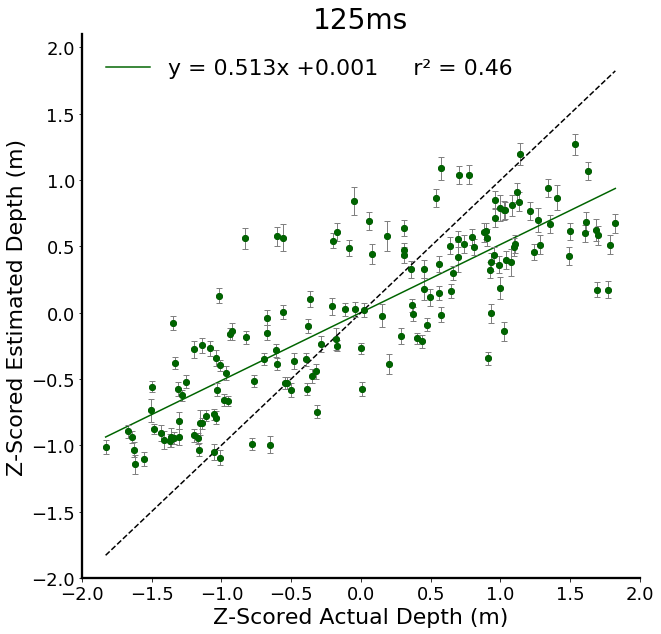

In [39]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_125).reshape(-1,1)
y = z_final_y_125
ste = z_ste_125
std = z_std_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("125ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.plot(X, X, color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

plt.ylim(2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_125 = copy.deepcopy(y - y_predicted)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zED_125.png', dpi=300)

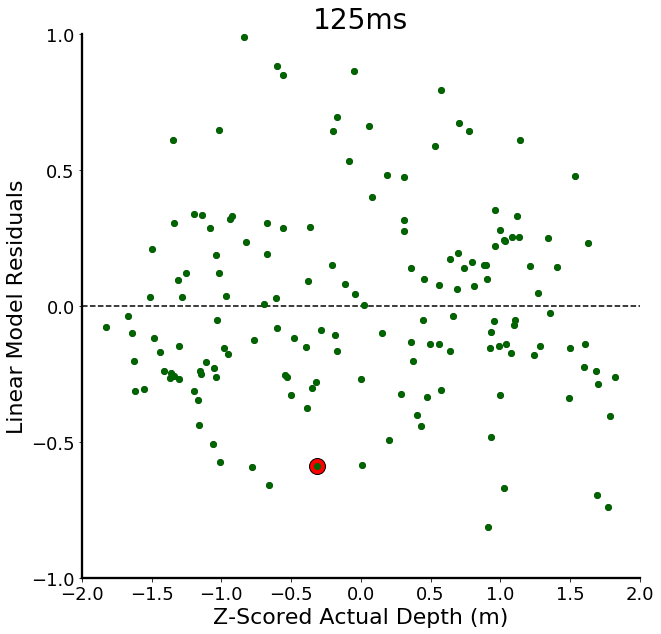

In [37]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_125).reshape(-1,1)
y = z_residuals_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);

plt.title("125ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Linear Model Residuals", fontsize = 22)

plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

plt.plot(X[pi], y[pi], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)
plt.plot([-2, -1, 0, 1, 2], [0, 0, 0, 0, 0], color = 'black',linestyle='--')  # solid

plt.ylim(-1,1)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1, 1.5, 0.5), fontsize=18)
plt.show()



# legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)


# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_resid_125_redPoint.png', dpi=300)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


m: [0.51310256]
b: 0.00099794606726333
R-squared:  0.6784855257844216


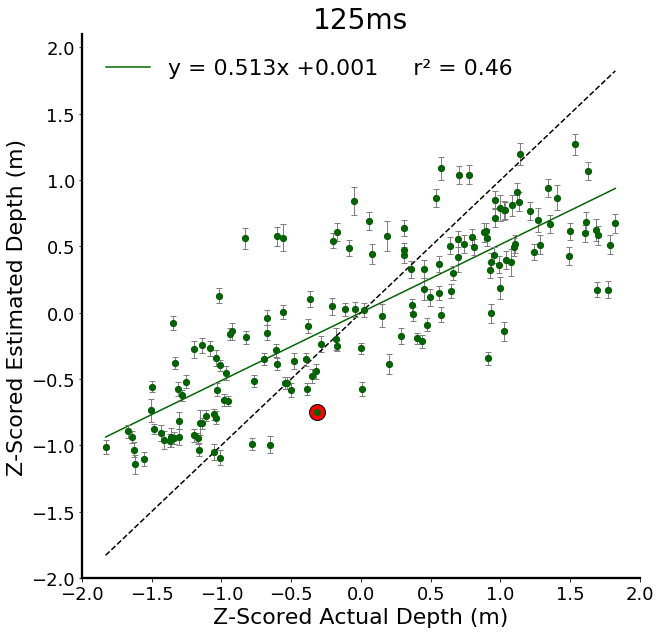

In [40]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_125).reshape(-1,1)
y = z_final_y_125
ste = z_ste_125
std = z_std_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = '  + str(round(float(reg.score(X, y)**2), 3)))
plt.title("125ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.plot(X, X, color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)


plt.plot(zsAD_125[pi], z_final_y_125[pi], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)

plt.ylim(2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)



legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_125 = copy.deepcopy(y - y_predicted)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zED_125_redPoint.png', dpi=300)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


m: [0.55075569]
b: 0.0010073226367152072
R-squared:  0.7322942306805682


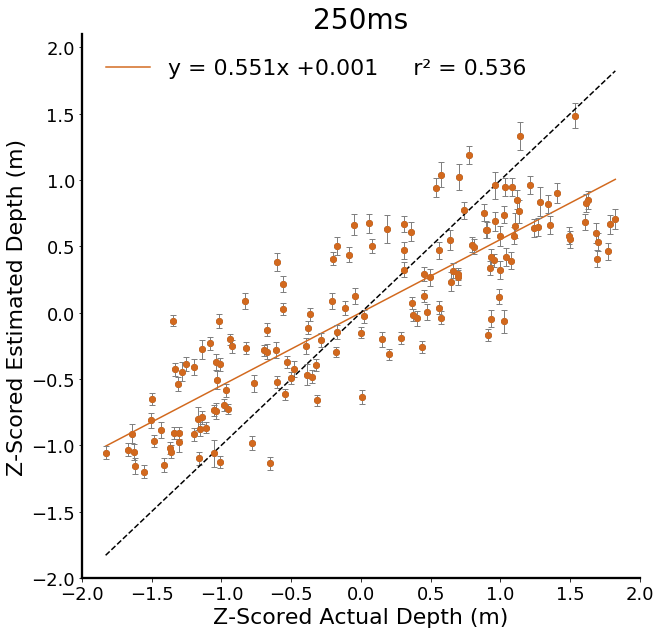

In [41]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X = np.array(zsAD_250).reshape(-1,1)
y = z_final_y_250
ste = z_ste_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("250ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)
plt.plot(X, X,  color = 'black',linestyle='--')  # solid

plt.ylim(2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_250 = copy.deepcopy(y - y_predicted)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zED_250.png', dpi=300)

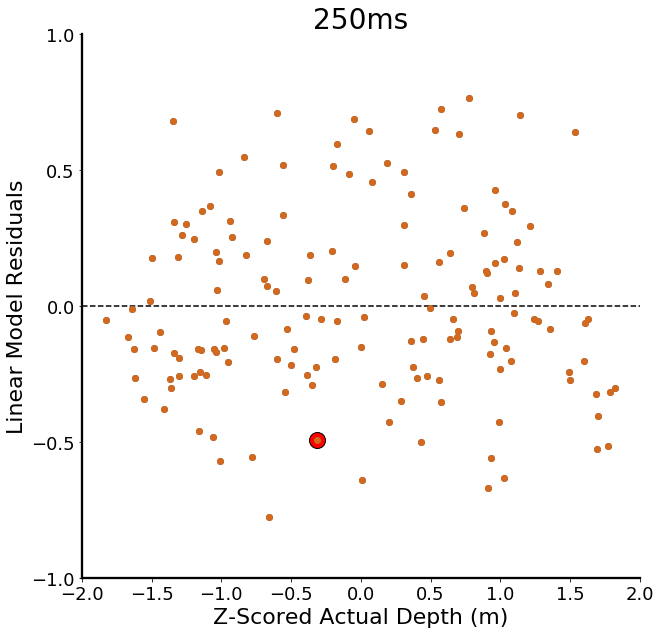

In [42]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_250).reshape(-1,1)
y = z_residuals_250

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);

plt.title("250ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Linear Model Residuals", fontsize = 22)

plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

plt.plot(X[pj], y[pj], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)

plt.plot([-2, -1, 0, 1, 2], [0, 0, 0, 0, 0], color = 'black',linestyle='--')  # solid

plt.ylim(-1,1)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1, 1.5, 0.5), fontsize=18)

plt.show();

# legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)


# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_resid_250_redPoint.png', dpi=300)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


m: [0.55075569]
b: 0.0010073226367152072
R-squared:  0.7322942306805682


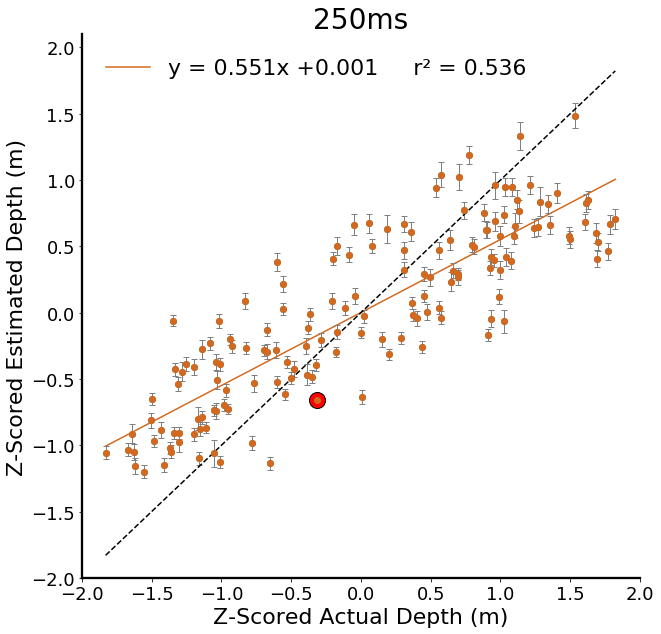

In [43]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X = np.array(zsAD_250).reshape(-1,1)
y = z_final_y_250
ste = z_ste_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("250ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)
plt.plot(X, X, color = 'black',linestyle='--')  # solid

plt.plot(zsAD_250[pj], z_final_y_250[pj], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)

plt.ylim(2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_250 = copy.deepcopy(y - y_predicted)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zED_250_redPoint.png', dpi=300)

/Users/prachimahableshwarkar/opt/anaconda3/envs/defaultenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical bottom == top == 2 results in singular transformations; automatically expanding.


m: [0.5710556]
b: 0.0010623664920809174
R-squared:  0.7352421581453548


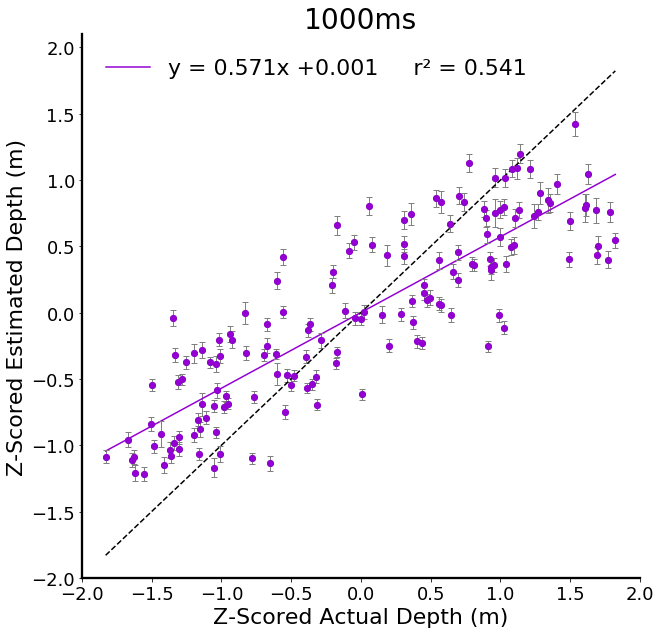

In [44]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_1000).reshape(-1,1)
y = z_final_y_1000
ste = z_ste_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = '  + str(round(float(reg.score(X, y)**2), 3)))
plt.title("1000ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)
plt.plot(X, X, color = 'black',linestyle='--')  # solid

plt.ylim(2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 0.5), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_1000 = copy.deepcopy(y - y_predicted)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zED_1000.png', dpi=300)

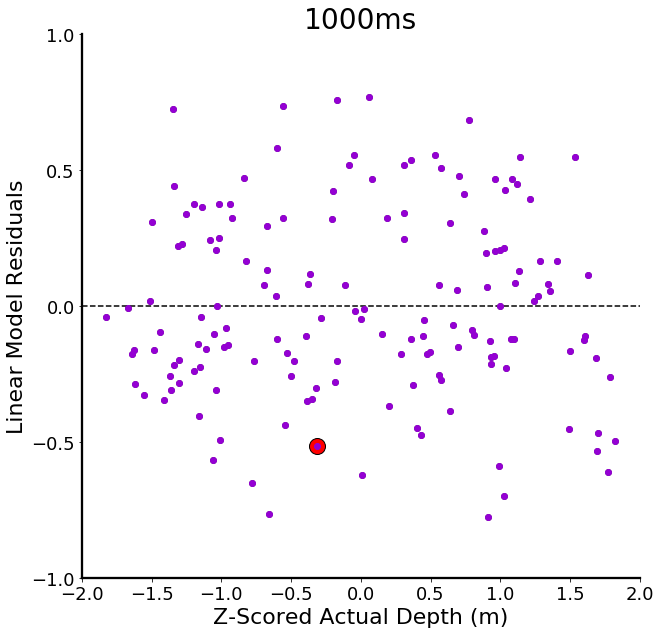

In [46]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_1000).reshape(-1,1)
y = z_residuals_1000

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);

plt.title("1000ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Linear Model Residuals", fontsize = 22)

plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.plot(X[pk], y[pk], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)
plt.plot([-2, -1, 0, 1, 2], [0, 0, 0, 0, 0], color = 'black',linestyle='--')  # solid

plt.ylim(-1,1)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1, 1.5, 0.5), fontsize=18)

plt.show();
# legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)


# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_resid_1000_redPoint.png', dpi=300)

### Save residuals as npy files

In [57]:
destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/residuals/'

with open(destpath + 'z_residuals_125.npy', 'wb') as f:
    np.save(f, z_residuals_125)
with open(destpath + 'z_residuals_250.npy', 'wb') as f:
    np.save(f, z_residuals_250)
with open(destpath + 'z_residuals_1000.npy', 'wb') as f:
    np.save(f, z_residuals_1000)

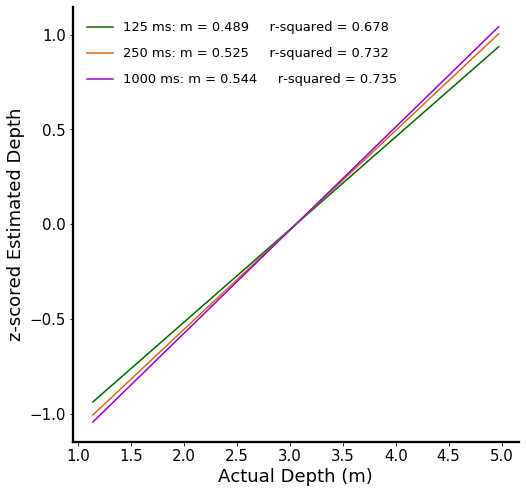

In [52]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
#run regression
z_X_125 = np.array(z_stim_125).reshape(-1,1)
z_y_125 = z_final_y_125
z_ste_125 = z_ste_125
z_reg_125 = LinearRegression().fit(z_X_125, z_y_125)

#Generated Predictions
z_y_predicted_125 = z_reg_125.predict(z_X_125)
#Plot Our Actual and Predicted Values
plt.plot(z_X_125,z_y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(z_reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(z_reg_125.score(z_X_125, z_y_125)), 3)))

#run regression
z_X_250 = np.array(z_stim_250).reshape(-1,1)
z_y_250 = z_final_y_250
z_ste_250 = z_ste_250
z_reg_250 = LinearRegression().fit(z_X_250, z_y_250)

#Generated Predictions
z_y_predicted_250 = z_reg_250.predict(z_X_250)
#Plot Our Actual and Predicted Values
plt.plot(z_X_250,z_y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(z_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(z_reg_250.score(z_X_250, z_y_250)), 3)))

#run regression
z_X_1000 = np.array(z_stim_1000).reshape(-1,1)
z_y_1000 = z_final_y_1000
z_ste_1000 = z_ste_1000
z_reg_1000 = LinearRegression().fit(z_X_1000, z_y_1000)

#Generated Predictions
z_y_predicted_1000 = z_reg_1000.predict(z_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(z_X_1000,z_y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(z_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(z_reg_1000.score(z_X_1000, z_y_1000)), 3)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Actual Depth (m)", fontsize = 18)
plt.ylabel("z-scored Estimated Depth", fontsize = 18)


legend = plt.legend(loc = 2, fontsize = 13, borderpad = 0.6, labelspacing = 1, frameon=False)



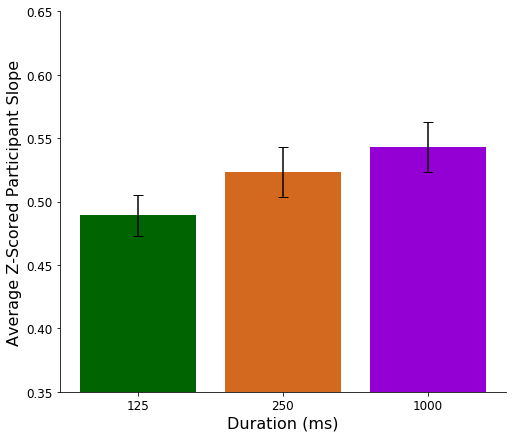

In [59]:
durations = ['125', '250', '1000']

zs_slopes = [zs_avg_slope_125, zs_avg_slope_250, zs_avg_slope_1000]
zs_slopes_sem = [zs_ste_slope_125, zs_ste_slope_250, zs_ste_slope_1000]

fig, ax = plt.subplots(figsize=[8,7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.ylim(0.35, 0.6)
plt.yticks(np.arange(0.35, 0.65, 0.05),fontsize=12)

# creating the bar plot
plt.bar(durations, zs_slopes, yerr = zs_slopes_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Z-Scored Participant Slope", fontsize=16)

plt.show()

### Between duration linear regression models of estimated depth

m: [1.0149891]
b: -5.581743618477287e-06
R-squared:  0.9650685304420563


0.965

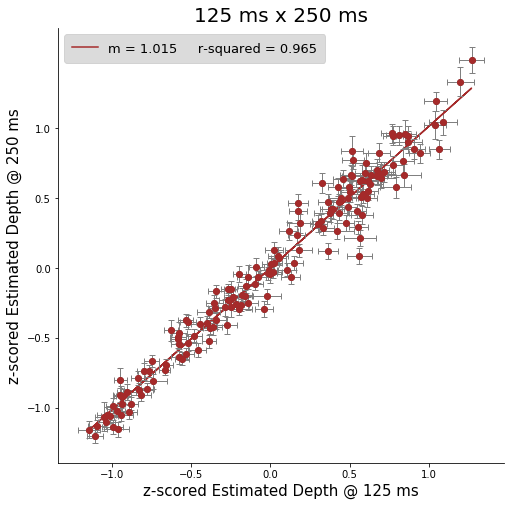

In [60]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_final_y_125).reshape(-1,1)
y = z_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 250 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth @ 250 ms", fontsize = 15)
plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)


plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))


legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

m: [1.04232121]
b: 2.2186144053178885e-05
R-squared:  0.9504833708779683


0.95

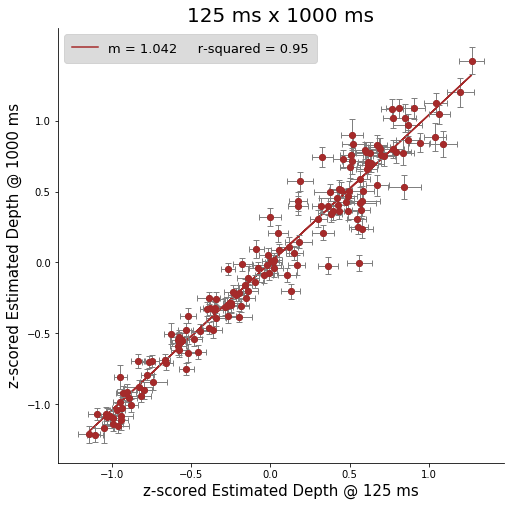

In [61]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_final_y_125).reshape(-1,1)
y = z_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 1000 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth @ 125 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth @ 1000 ms", fontsize = 15)
plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)

plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

m: [1.0220218]
b: 3.286079408092667e-05
R-squared:  0.9754978144006529


0.975

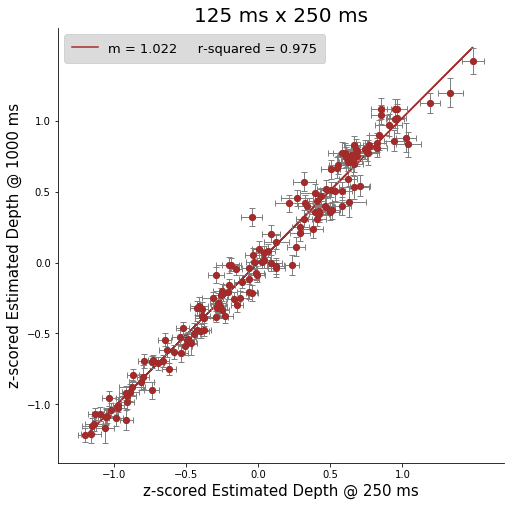

In [60]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#run regression
X = np.array(z_final_y_250).reshape(-1,1)
y = z_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='brown', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms x 250 ms", fontsize = 20)
plt.xlabel("z-scored Estimated Depth @ 250 ms", fontsize = 15)
plt.ylabel("z-scored Estimated Depth @ 1000 ms", fontsize = 15)
plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "brown", mec = "brown", capsize = 3)

plt.xticks(np.arange(-1,1.5, 0.5))
plt.yticks(np.arange(-1,1.5, 0.5))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# Model Residuals

In [62]:
stats.pearsonr(z_residuals_125, z_residuals_250)

(0.9458834386779005, 3.628525087393369e-77)

In [63]:
stats.pearsonr(z_residuals_125, z_residuals_1000)

(0.920736446072009, 7.916300882202577e-65)

In [64]:
stats.pearsonr(z_residuals_1000, z_residuals_250)

(0.9537181544376172, 2.889129724102642e-82)

m: [0.8917611]
b: -7.94001932560884e-17
R-squared:  0.8946954795651295


0.895

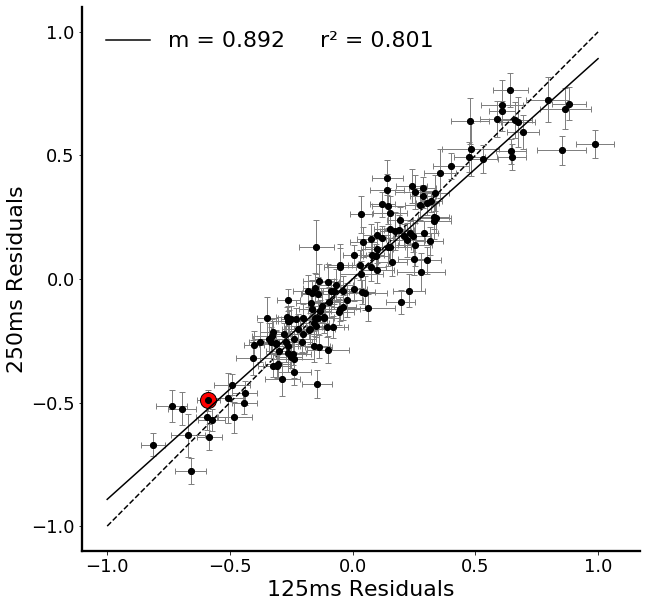

In [65]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)



#run regression
X = np.array(z_residuals_125).reshape(-1,1)
y = z_residuals_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);

plt.plot([-1, -0.5, 0, 0.5, 1], [-1, -0.5, 0, 0.5, 1], color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "black", capsize = 3)


plt.plot(z_residuals_125[pi], z_residuals_250[pj], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)

a = np.linspace(-1,1,156)
b = reg.coef_[0]*a

plt.plot(a,b,color='black', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r' + get_super('2') + ' = 0.801')

# plt.title("Residual Correlation", fontsize = 28)
plt.xlabel("125ms Residuals", fontsize = 22)
plt.ylabel("250ms Residuals", fontsize = 22)

plt.xticks(np.arange(-1,1.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1,1.5, 0.5), fontsize=18)

legend = plt.legend(loc = 0, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'resid125_resid250.png', dpi=300)

m: [0.89328244]
b: 1.2840645230206082e-16
R-squared:  0.8477556031253135


0.848

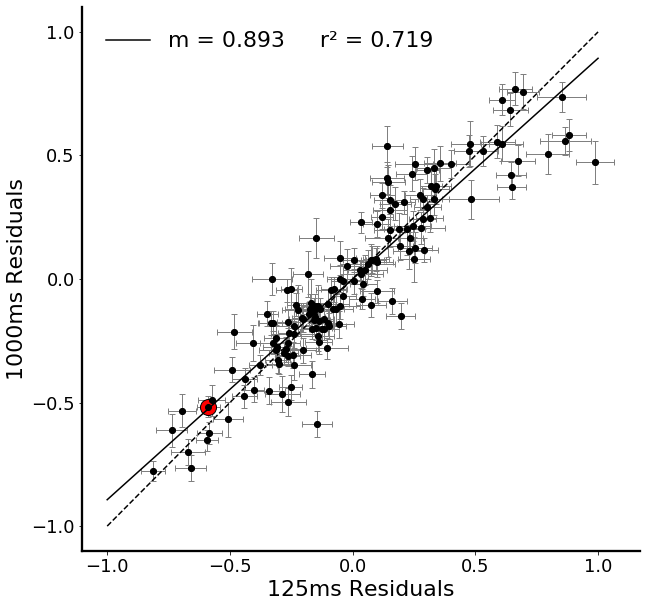

In [66]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_residuals_125).reshape(-1,1)
y = z_residuals_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot([-1, -0.5, 0, 0.5, 1], [-1, -0.5, 0, 0.5, 1], color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, xerr= z_ste_125, yerr= z_ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "black", capsize = 3)


plt.plot(z_residuals_125[pi], z_residuals_1000[pk], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)


a = np.linspace(-1,1,156)
b = reg.coef_[0]*a
plt.plot(a,b,color='black', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r' + get_super('2') + ' = '  + str(round(float(reg.score(X, y)**2), 3)))

plt.xlabel("125ms Residuals", fontsize = 22)
plt.ylabel("1000ms Residuals", fontsize = 22)

plt.xticks(np.arange(-1,1.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1,1.5, 0.5), fontsize=18)

legend = plt.legend(loc = 0, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'resid125_resid1000.png', dpi=300)

m: [0.98143742]
b: 2.0638422666524254e-16
R-squared:  0.9095783181038949


0.91

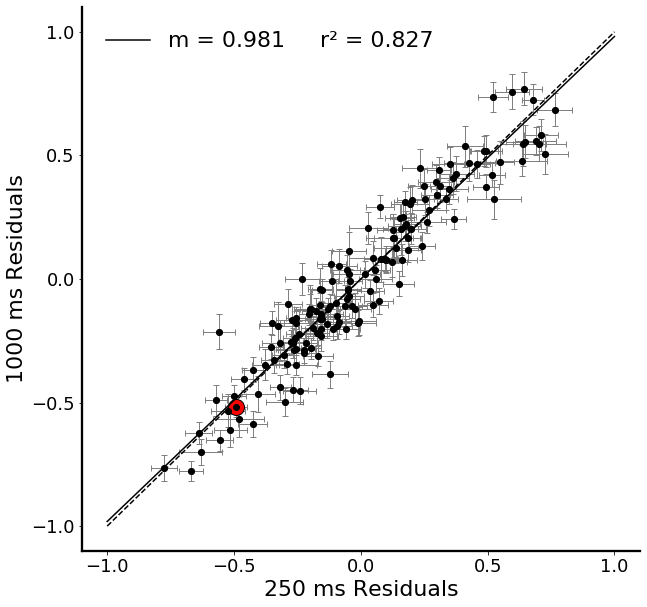

In [67]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_residuals_250).reshape(-1,1)
y = z_residuals_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot([-1, -0.5, 0, 0.5, 1], [-1, -0.5, 0, 0.5, 1], color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, xerr= z_ste_250, yerr= z_ste_1000, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "black", mec = "black", capsize = 3)

plt.plot(z_residuals_250[pj], z_residuals_1000[pk], marker="o", markersize=16, markeredgecolor="black", markerfacecolor="red", alpha=1)

a = np.linspace(-1,1,156)
b = reg.coef_[0]*a
plt.plot(a,b,color='black', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r' + get_super('2') + ' = '  + str(round(float(reg.score(X, y)**2), 3)))


# plt.title("Residual Correlation", fontsize = 28)
plt.xlabel("250 ms Residuals", fontsize = 22)
plt.ylabel("1000 ms Residuals", fontsize = 22)

plt.xticks(np.arange(-1,1.5, 0.5), fontsize=18)
plt.yticks(np.arange(-1,1.5, 0.5), fontsize=18)

legend = plt.legend(loc = 0, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'resid250_resid1000.png', dpi=300)

# Response Time Plots

m: [0.08937298]
b: 0.0002225841939968591
R-squared:  0.4014422726788154


0.401

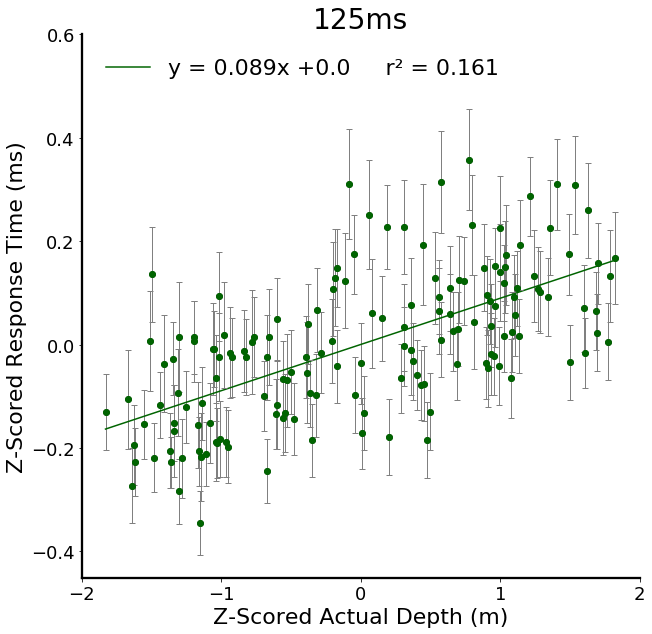

In [68]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_125).reshape(-1,1)
y = z_RT_125
ste = z_RT_ste_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("125ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1.0), fontsize=18)
plt.yticks(np.arange(-.4, .62, 0.2), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zRT_125.png', dpi=300)

m: [0.11484824]
b: 0.0002688503187134303
R-squared:  0.5131734993841284


0.513

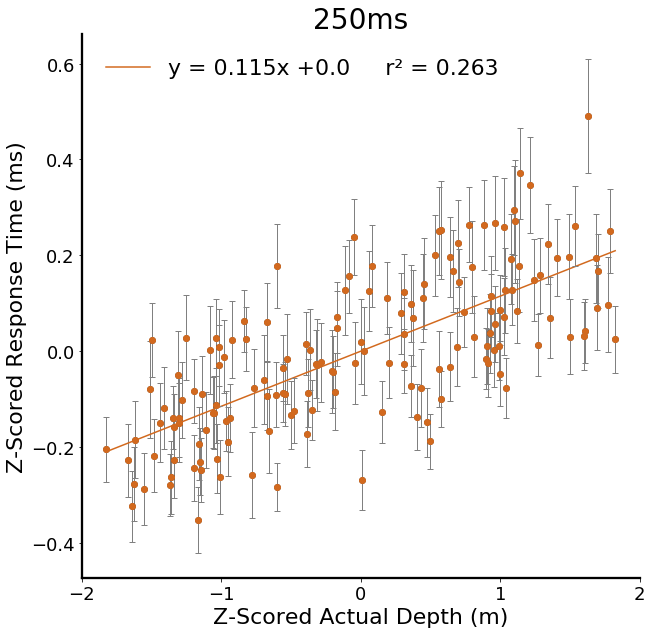

In [69]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_250).reshape(-1,1)
y = z_RT_250
ste = z_RT_ste_250

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("250ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1.0), fontsize=18)
plt.yticks(np.arange(-.4, .62, 0.2), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zRT_250.png', dpi=300)

m: [0.09868796]
b: 0.0001678921835421624
R-squared:  0.4967626717556568


0.497

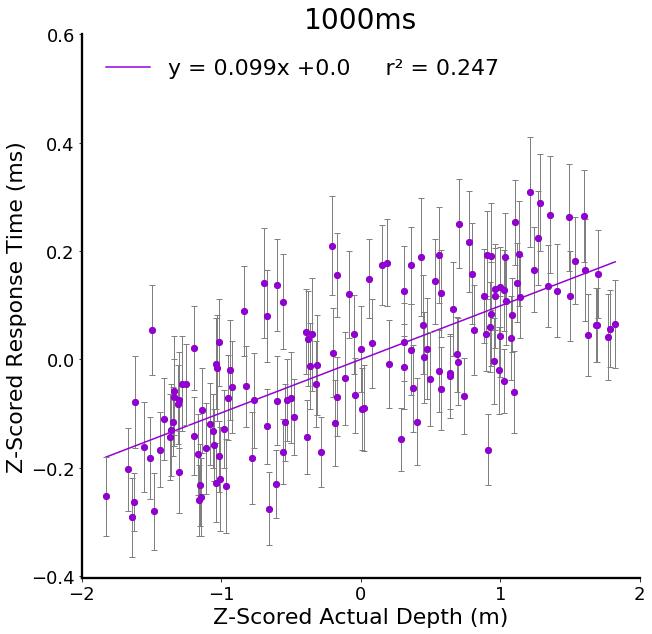

In [70]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(zsAD_1000).reshape(-1,1)
y = z_RT_1000
ste = z_RT_ste_1000

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("1000ms", fontsize = 28)
plt.xlabel("Z-Scored Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1.0), fontsize=18)
plt.yticks(np.arange(-.4, .62, 0.2), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zAD_zRT_1000.png', dpi=300)

m: [0.16912639]
b: 5.380517958190873e-05
R-squared:  0.557829099859581


0.558

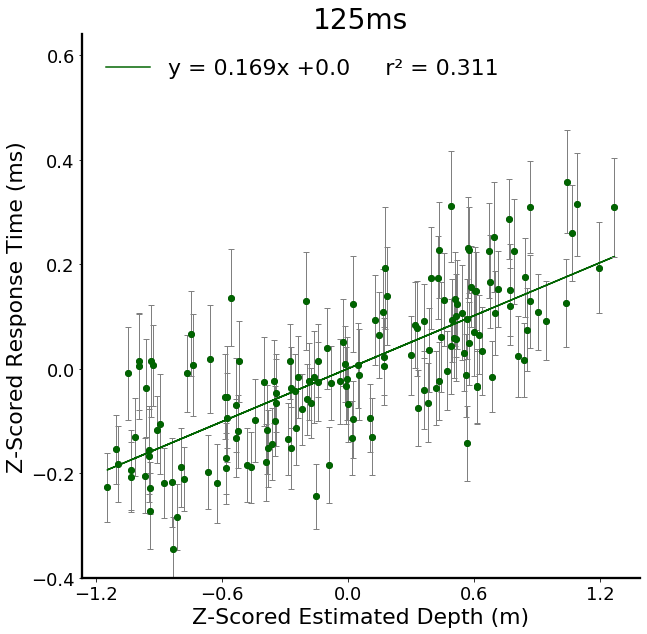

In [71]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_final_y_125).reshape(-1,1)
y = z_RT_125
ste = z_RT_ste_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("125ms", fontsize = 28)
plt.xlabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)


plt.ylim(-0.4, 0.64)

plt.xticks(np.arange(-1.2, 1.6, 0.6), fontsize=18)
plt.yticks(np.arange(-.4, .64, 0.2), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zED_zRT_125.png', dpi=300)

m: [0.20724363]
b: 6.008911572997431e-05
R-squared:  0.6921660192300161


0.692

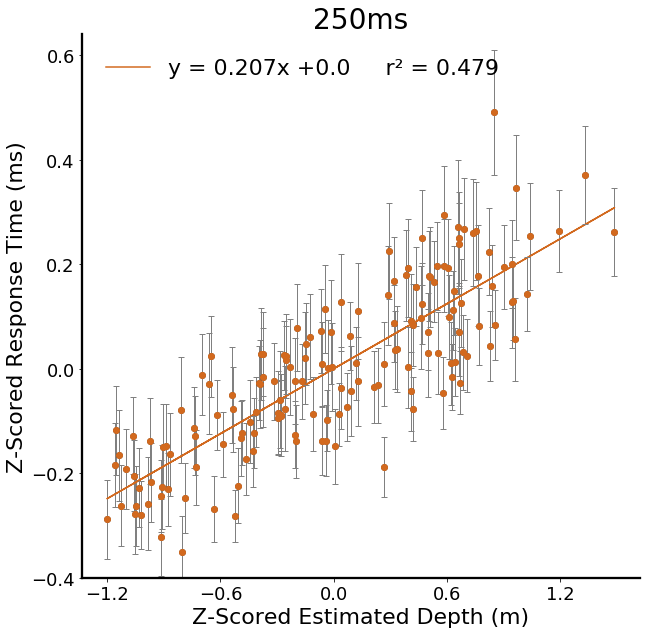

In [72]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_final_y_250).reshape(-1,1)
y = z_RT_250
ste = z_RT_ste_250

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("250ms", fontsize = 28)
plt.xlabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)


plt.ylim(-0.4, 0.64)

plt.xticks(np.arange(-1.2, 1.6, 0.6), fontsize=18)
plt.yticks(np.arange(-.4, .64, 0.2), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zED_zRT_250.png', dpi=300)

m: [0.17048486]
b: -1.3225216767297101e-05
R-squared:  0.6575346084421514


0.658

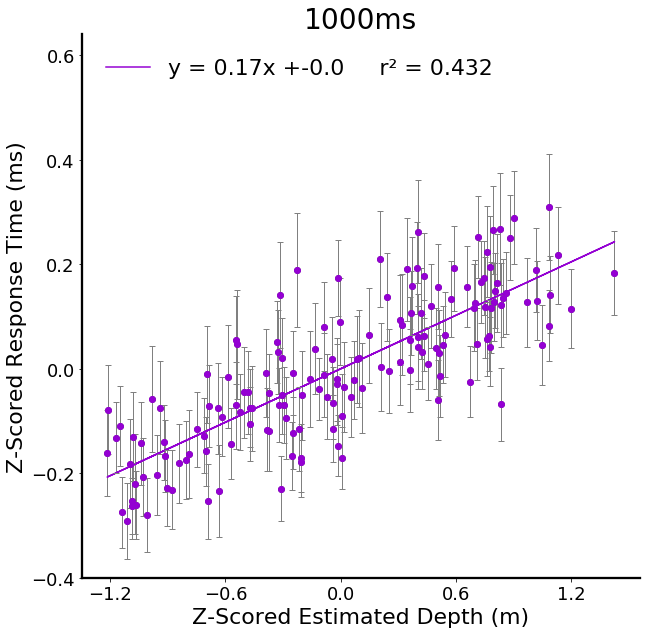

In [73]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_final_y_1000).reshape(-1,1)
y = z_RT_1000
ste = z_RT_ste_1000

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("1000ms", fontsize = 28)
plt.xlabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.ylim(-0.4, 0.64)

plt.xticks(np.arange(-1.2, 1.6, 0.6), fontsize=18)
plt.yticks(np.arange(-.4, .64, 0.2), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'zED_zRT_1000.png', dpi=300)

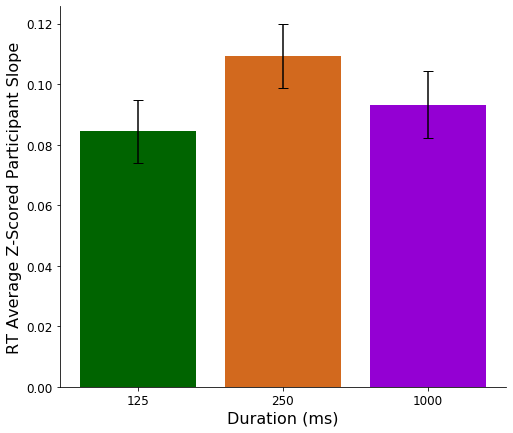

In [77]:
# creating the dataset
durations = ['125', '250', '1000']

RT_zs_slopes = [RT_zs_avg_slope_125, RT_zs_avg_slope_250, RT_zs_avg_slope_1000]
RT_zs_slopes_sem = [RT_zs_ste_slope_125, RT_zs_ste_slope_250, RT_zs_ste_slope_1000]

fig, ax = plt.subplots(figsize=[8,7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# creating the bar plot
plt.bar(durations, RT_zs_slopes, yerr = RT_zs_slopes_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("RT Average Z-Scored Participant Slope", fontsize=16)

plt.show()

### Save data by duration

In [83]:
n_destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'

# 125 ms
with open(n_destpath + 'X_125.npy', 'wb') as f:
    
    np.save(f, z_stim_125)
with open(n_destpath + 'z_final_y_125.npy', 'wb') as f:
    np.save(f, z_final_y_125)
with open(n_destpath + 'z_std_125.npy', 'wb') as f:
    np.save(f, z_std_125)
with open(n_destpath + 'z_ste_125.npy', 'wb') as f:
    np.save(f, z_ste_125)
with open(n_destpath + 'z_final_stim_125.npy', 'wb') as f:
    np.save(f, z_final_x_125)
    
# 250 ms    
with open(n_destpath + 'X_250.npy', 'wb') as f:
    np.save(f, z_stim_250)
with open(n_destpath + 'z_final_y_250.npy', 'wb') as f:
    np.save(f, z_final_y_250)
with open(n_destpath + 'z_std_250.npy', 'wb') as f:
    np.save(f, z_std_250)
with open(n_destpath + 'z_ste_250.npy', 'wb') as f:
    np.save(f, z_ste_250)
with open(n_destpath + 'z_final_stim_250.npy', 'wb') as f:
    np.save(f, z_final_x_250)
    
# 1000 ms
with open(n_destpath + 'X_1000.npy', 'wb') as f:
    np.save(f, z_stim_1000)
with open(n_destpath + 'z_final_y_1000.npy', 'wb') as f:
    np.save(f, z_final_y_1000)
with open(n_destpath + 'z_std_1000.npy', 'wb') as f:
    np.save(f, z_std_1000)
with open(n_destpath + 'z_ste_1000.npy', 'wb') as f:
    np.save(f, z_ste_1000)    
with open(n_destpath + 'z_final_stim_1000.npy', 'wb') as f:
    np.save(f, z_final_x_1000)

# Raw Data Analyses

In [78]:
duration_data = [final_data[final_data['duration'] == 125], final_data[final_data['duration'] == 250], final_data[final_data['duration'] == 1000]]


In [79]:
raw_trial_pivot = trial_pivotTable(duration_data)


In [81]:
trial_raw_final = trial_getxy(raw_trial_pivot)


### Raw Data

In [82]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting

final_x_125 = trial_plot_data[0][0]
final_y_125 = trial_plot_data[1][0]
ste_125 = trial_plot_data[2][0]
stim_125 = trial_plot_data[3][0]
std_125 = trial_plot_data[4][0]
RT_125 = trial_plot_data[5][0]
ste_RT_125 = trial_plot_data[6][0]

final_x_250 = trial_plot_data[0][1]
final_y_250 = trial_plot_data[1][1]
ste_250 = trial_plot_data[2][1]
stim_250 = trial_plot_data[3][1]
std_250 = trial_plot_data[4][1]
RT_250 = trial_plot_data[5][1]
ste_RT_250 = trial_plot_data[6][1]

final_x_1000 = trial_plot_data[0][2]
final_y_1000 = trial_plot_data[1][2]
ste_1000 = trial_plot_data[2][2]
stim_1000 = trial_plot_data[3][2]
std_1000 = trial_plot_data[4][2]
RT_1000 = trial_plot_data[5][2]
ste_RT_1000 = trial_plot_data[6][2]


### Save raw data

In [83]:
# destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/'

# 125 ms
with open(destpath + 'X_125.npy', 'wb') as f:
    np.save(f, stim_125)
with open(destpath + 'final_y_125.npy', 'wb') as f:
    np.save(f, final_y_125)
with open(destpath + 'std_125.npy', 'wb') as f:
    np.save(f, std_125)
with open(destpath + 'ste_125.npy', 'wb') as f:
    np.save(f, ste_125)
with open(destpath + 'final_stim_125.npy', 'wb') as f:
    np.save(f, final_x_125)
    
# 250 ms    
with open(destpath + 'X_250.npy', 'wb') as f:
    np.save(f, stim_250)
with open(destpath + 'final_y_250.npy', 'wb') as f:
    np.save(f, final_y_250)
with open(destpath + 'std_250.npy', 'wb') as f:
    np.save(f, std_250)
with open(destpath + 'ste_250.npy', 'wb') as f:
    np.save(f, ste_250)
with open(destpath + 'final_stim_250.npy', 'wb') as f:
    np.save(f, final_x_250)
    
# 1000 ms
with open(destpath + 'X_1000.npy', 'wb') as f:
    np.save(f, stim_1000)
with open(destpath + 'final_y_1000.npy', 'wb') as f:
    np.save(f, final_y_1000)
with open(destpath + 'std_1000.npy', 'wb') as f:
    np.save(f, std_1000)
with open(destpath + 'ste_1000.npy', 'wb') as f:
    np.save(f, ste_1000)    
with open(destpath + 'final_stim_1000.npy', 'wb') as f:
    np.save(f, final_x_1000)

In [84]:
scipy.stats.pearsonr(stim_125, final_y_125)

(0.7760859088230985, 1.204316986107949e-32)

In [85]:
scipy.stats.pearsonr(stim_250, final_y_250)

(0.7892129695807069, 1.9932725159018375e-34)

In [86]:
scipy.stats.pearsonr(stim_1000, final_y_1000)

(0.8174182530881531, 1.0090233617557758e-38)

m: [0.58242683]
b: 1.728615407930692
R-squared:  0.6023093378737747


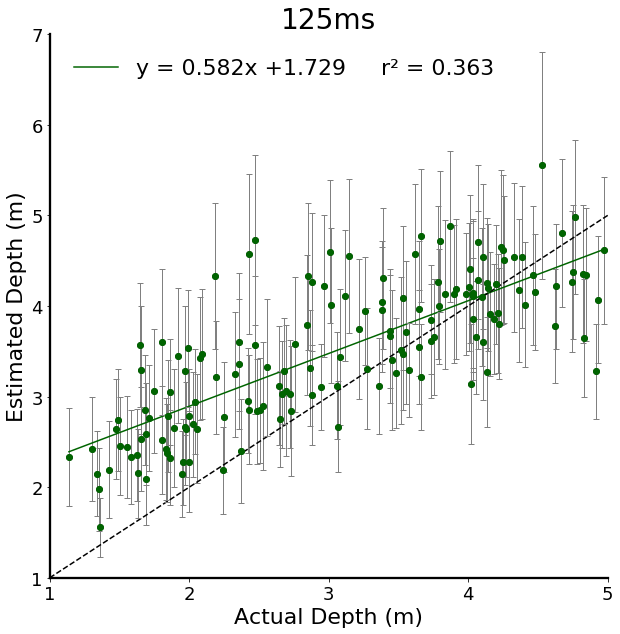

In [87]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.title("125 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Estimated Depth (m)", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
#run regression
X = np.array(stim_125).reshape(-1,1)
y = final_y_125
ste = ste_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.title("125ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Estimated Depth (m)", fontsize = 22)
plt.plot([1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], color = 'black',linestyle='--')  # solid
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)


plt.ylim(1,7)
plt.xlim(1,5)

plt.xticks(np.arange(1, 6, 1), fontsize=18)
plt.yticks(np.arange(1, 8, 1), fontsize=18)


legend = plt.legend(loc = 0, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

residuals_125 = copy.deepcopy(y - y_predicted)

# d = '/Users/pmahableshwarkar/Documents/Depth_Project/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'AD_ED_125.png', dpi=300)

m: [0.66914796]
b: 1.3060307113039458
R-squared:  0.6228571113543978


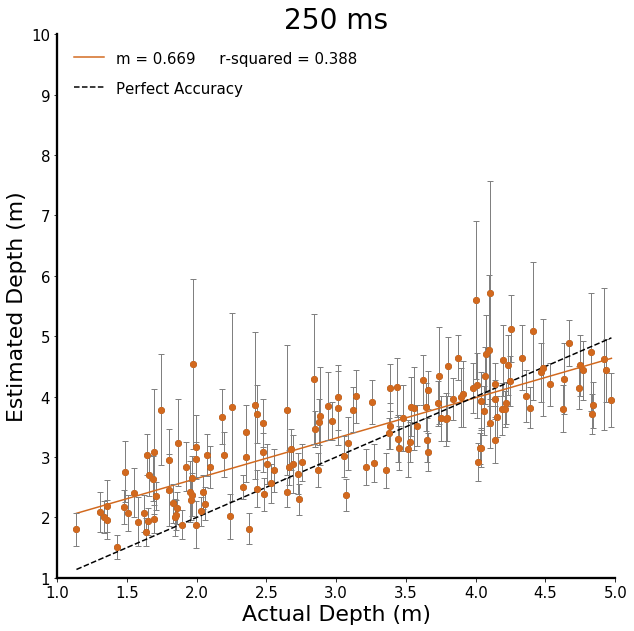

In [107]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.title("250 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Estimated Depth (m)", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#run regression
X = np.array(stim_250).reshape(-1,1)
y = final_y_250
ste = ste_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)
plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


plt.xlim([1,5])
plt.ylim([1,10])

legend = plt.legend(loc = 2, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

residuals_250 = copy.deepcopy(y - y_predicted)

m: [0.75768617]
b: 1.704866090891362
R-squared:  0.6681726004816879


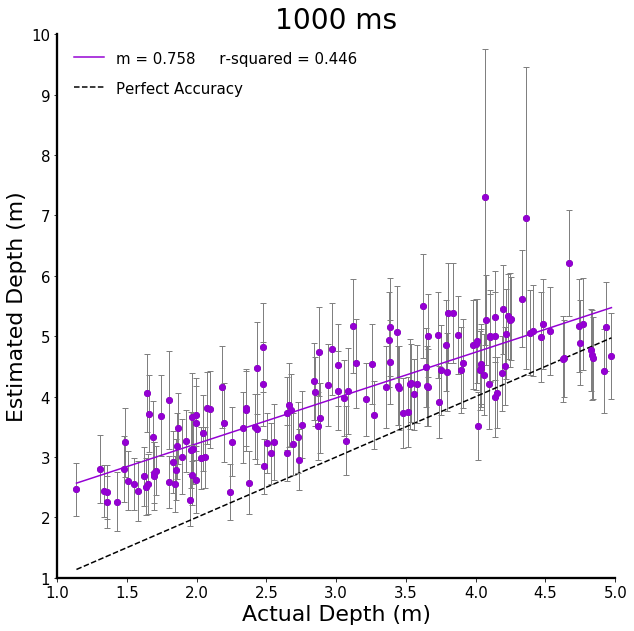

In [108]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.title("1000 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Estimated Depth (m)", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
ste = ste_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)**2), 3)))
plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

plt.xlim([1,5])
plt.ylim([1,10])

legend = plt.legend(loc = 2, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

residuals_1000 = copy.deepcopy(y - y_predicted)

<Figure size 720x576 with 0 Axes>

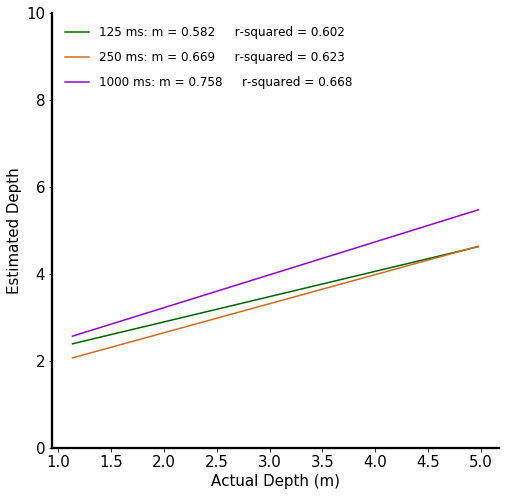

In [109]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [10,8])

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
# plt.title("125 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Estimated Depth (m)", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#run regression
X_125 = np.array(stim_125).reshape(-1,1)
y_125 = final_y_125
ste_125 = ste_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.plot(X_125,y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(reg_125.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_125.score(X_125, y_125)), 3)))

#run regression
X_250 = np.array(stim_250).reshape(-1,1)
y_250 = final_y_250
ste_250 = ste_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)

#run regression
X_1000 = np.array(stim_1000).reshape(-1,1)
y_1000 = final_y_1000
ste_1000 = ste_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_1000.score(X_1000, y_1000)), 3)))
plt.xlabel("Actual Depth (m)", fontsize = 15)
plt.ylabel("Estimated Depth", fontsize = 15)

plt.ylim([0,10])

legend = plt.legend(loc = 2, fontsize = 12, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.show();


### Average participant slopes

In [110]:
raw_avg_slope_125 = np.mean(np.array(raw_slopes_125['slope']))
raw_ste_slope_125 = stats.sem(np.array(raw_slopes_125['slope']))

raw_avg_slope_250 = np.mean(np.array(raw_slopes_250['slope']))
raw_ste_slope_250 = stats.sem(np.array(raw_slopes_250['slope']))

raw_avg_slope_1000 = np.mean(np.array(raw_slopes_1000['slope']))
raw_ste_slope_1000 = stats.sem(np.array(raw_slopes_1000['slope']))

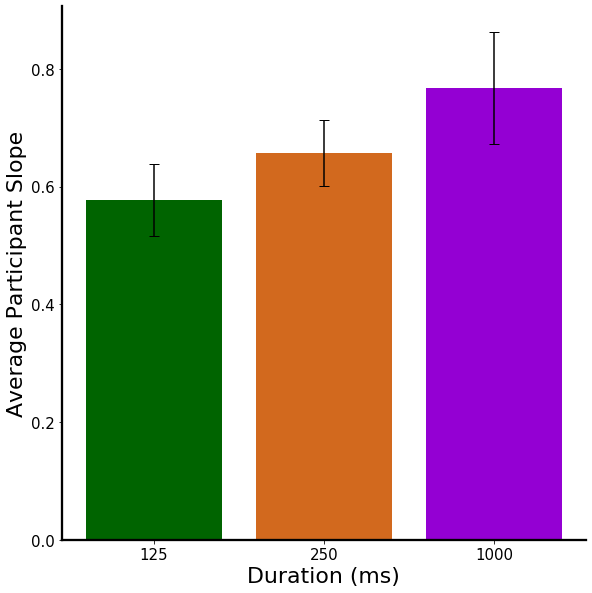

In [93]:
# creating the dataset
durations = ['125', '250', '1000']

raw_slopes = [raw_avg_slope_125, raw_avg_slope_250, raw_avg_slope_1000]
raw_slopes_sem = [raw_ste_slope_125, raw_ste_slope_250, raw_ste_slope_1000]

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.tight_layout()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# creating the bar plot
plt.bar(durations, raw_slopes, yerr = raw_slopes_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
plt.xlabel("Duration (ms)", fontsize=22)
plt.ylabel("Average Participant Slope", fontsize=22)
plt.show()

## Raw RT

In [111]:
stats.pearsonr(stim_125, RT_125)

(0.630439307477874, 1.1560296613638593e-18)

In [112]:
stats.pearsonr(stim_250, RT_250)

(0.6987485945733782, 3.612129999785242e-24)

In [113]:
stats.pearsonr(stim_1000, RT_1000)

(0.6732780473890633, 6.059815854462449e-22)

m: [80.57695924]
b: 3012.449186034922
R-squared:  0.39745372041318106


0.397

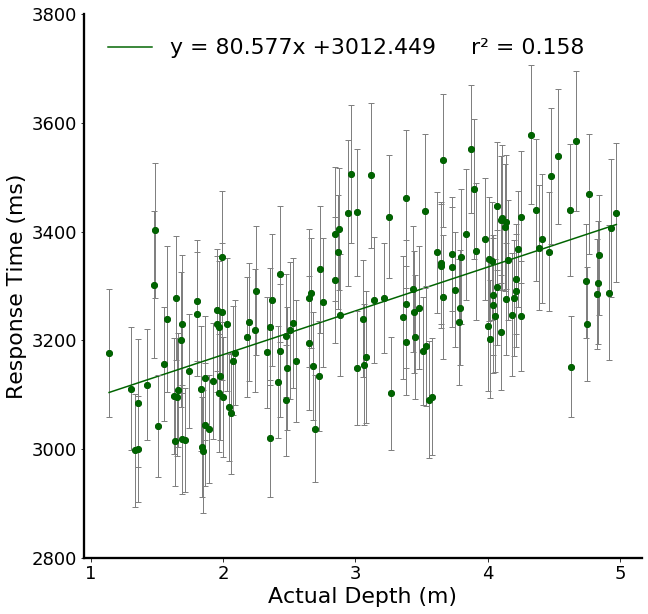

In [114]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(stim_125).reshape(-1,1)
y = RT_125
ste = ste_RT_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg.score(X, y)**2), 3)))
# plt.title("125ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Response Time (ms)", fontsize = 22)

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

plt.xticks(np.arange(1,6, 1.0), fontsize=18)
plt.yticks(np.arange(2800, 3900, 200), fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

# d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
# plt.savefig(d + 'AD_RT_125.png', dpi=300)

In [115]:
print('250ms')
X = np.array(stim_250).reshape(-1,1)
y = RT_250

reg = LinearRegression().fit(X, y)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y)**2)

250ms
m: [98.57220683]
R-squared:  0.23838767035560315


In [116]:
print('1000ms')
X = np.array(stim_1000).reshape(-1,1)
y = RT_1000

reg = LinearRegression().fit(X, y)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y)**2)


1000ms
m: [78.94583022]
R-squared:  0.20548390816954323


### Save raw residuals

In [110]:
destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/raw/residuals/'

with open(destpath + 'residuals_125.npy', 'wb') as f:
    np.save(f, residuals_125)
with open(destpath + 'residuals_250.npy', 'wb') as f:
    np.save(f, residuals_250)
with open(destpath + 'residuals_1000.npy', 'wb') as f:
    np.save(f, residuals_1000)

# Age

### Extract participant age, z-scored slope, and raw slope

In [118]:
import datetime

subject_summary = subjectData(zscored_data)

subjID = []
age = []
duration_cond = []
zs_slope = []
raw_slope = []

for subj in final_data.subjID.unique():
    subj_age = final_data.loc[final_data['subjID']==subj].age.unique()[0]
    # all participants on Mechanical Turk are required to be over 18 years old
    # exclude erroneous reports of age that are below 18
    if subj_age < 18:
        print(subj_age)
        pass
    else:
        # subjects may mistakenly report birth year
        # calculate age accordingly 
        year = datetime.date.today().year
        if subj_age > 1900:
            subj_age = year - subj_age
        
        subj_zs_slope = subject_summary.loc[subject_summary["subjID"]==subj].slope.unique()[0]
        subj_raw_slope = raw_subject_summary.loc[raw_subject_summary["subjID"]==subj].slope.unique()[0]
        subj_duration_cond = final_data.loc[final_data['subjID']==subj].duration.unique()[0]

        subjID.append(subj) 
        age.append(subj_age)
        duration_cond.append(subj_duration_cond)
        zs_slope.append(subj_zs_slope)
        raw_slope.append(subj_raw_slope)
#         print(subj, subj_age, subj_duration_cond, subj_zs_slope, subj_raw_slope)

4


In [121]:
min(age), max(age), np.mean(age), np.std(age), len(age)

(20, 67, 39.113490364025694, 10.618051072971769, 467)

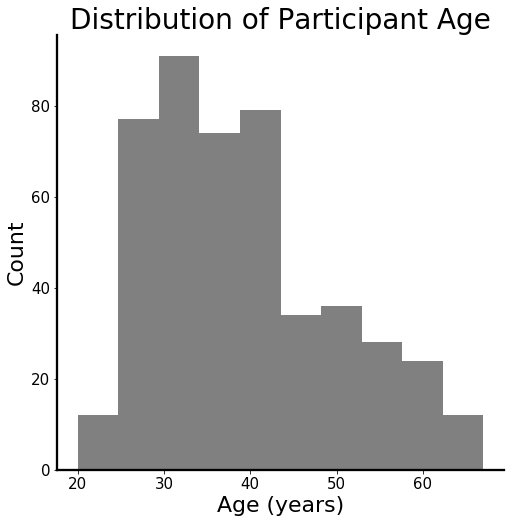

In [122]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Distribution of Participant Age', fontsize=28)
plt.ylabel('Count', fontsize=22)
plt.xlabel('Age (years)', fontsize=22)
plt.hist(age, color='gray')
plt.show();

In [123]:
# Calling DataFrame constructor after zipping both lists, with columns specified
df_age_analysis = pd.DataFrame(list(zip(subjID, age, duration_cond, zs_slope, raw_slope)),
               columns =['subjID', 'cleaned_age', 'duration', 'zs_slope', 'raw_slope'])

In [125]:
df_age_analysis

,subjID,cleaned_age,duration,zs_slope,raw_slope
0,541423,28,125,0.741418,0.863528
1,104257,34,125,0.581617,0.314636
2,928935,25,1000,0.558336,0.293113
3,596417,28,1000,0.754673,1.051256
4,480789,26,1000,0.275887,0.037957
...,...,...,...,...,...
462,352815,33,1000,0.748482,0.651701
463,394603,36,1000,0.685278,0.803610
464,757697,26,1000,0.497181,0.275333
465,508587,54,125,0.617442,0.356431


### Save age x slope data

In [117]:
df_age_analysis.to_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/age_slopes.csv', index=False)

In [126]:
df_age_125 = df_age_analysis.loc[df_age_analysis['duration']==125]
df_age_250 = df_age_analysis.loc[df_age_analysis['duration']==250]
df_age_1000 = df_age_analysis.loc[df_age_analysis['duration']==1000]

In [127]:
df_age_125_mean = df_age_125.groupby(['cleaned_age']).mean()
df_age_250_mean = df_age_250.groupby(['cleaned_age']).mean()
df_age_1000_mean = df_age_1000.groupby(['cleaned_age']).mean()


In [128]:
df_age_mean = df_age_analysis.groupby(['cleaned_age']).mean()


0.031131612271759486
0.025077969101328115
0.02269460089674595


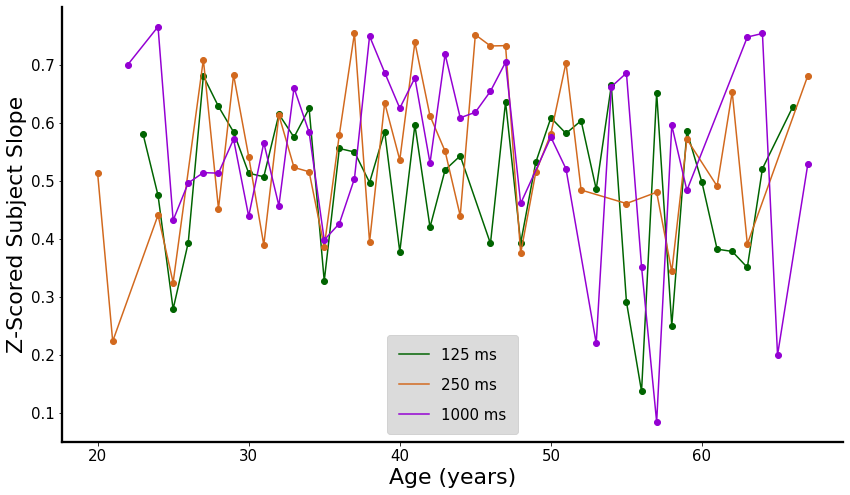

In [130]:
fig, ax = plt.subplots(figsize=[14,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Z-Scored Subject Slope', fontsize=22)
plt.xlabel('Age (years)', fontsize=22)


slope_125, intercept_125, r_value_125, p_value_125, std_err_125 = stats.linregress(df_age_125_mean.index, df_age_125_mean['zs_slope'])
# plt.plot(df_age_125_mean.index, df_age_125_mean['zs_slope'], label = '125 ms: m = ' + str(round(slope_125, 4)), color = "darkgreen")
plt.plot(df_age_125_mean.index, df_age_125_mean['zs_slope'], label = '125 ms', color = "darkgreen")


plt.plot(df_age_125_mean['zs_slope'], 'o', color = "darkgreen")

print(r_value_125 **2)

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(df_age_250_mean.index, df_age_250_mean['zs_slope'])
# plt.plot(df_age_250_mean.index, df_age_250_mean['zs_slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "chocolate")
plt.plot(df_age_250_mean.index, df_age_250_mean['zs_slope'], label = '250 ms', color = "chocolate")


plt.plot(df_age_250_mean['zs_slope'], 'o', color = "chocolate")

print(r_value_250 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(df_age_1000_mean.index, df_age_1000_mean['zs_slope'])
# plt.plot(df_age_1000_mean.index, df_age_1000_mean['zs_slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "darkviolet")
plt.plot(df_age_1000_mean.index, df_age_1000_mean['zs_slope'], label = '1000 ms', color = "darkviolet")


plt.plot(df_age_1000_mean['zs_slope'], 'o', color = "darkviolet")

print(r_value_1000 **2)


legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

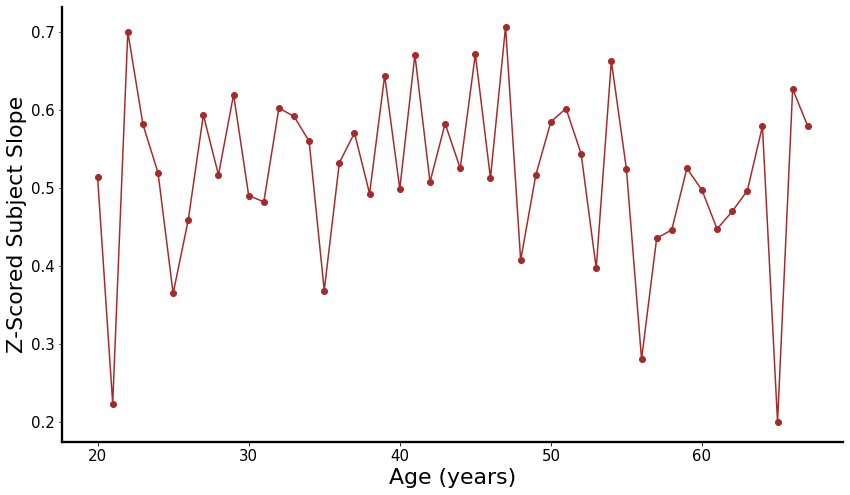

In [133]:
fig, ax = plt.subplots(figsize=[14,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Z-Scored Subject Slope', fontsize=22)
plt.xlabel('Age (years)', fontsize=22)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_age_mean.index, df_age_mean['zs_slope'])
plt.plot(df_age_mean.index, df_age_mean['zs_slope'], label = 'm = ' + str(round(slope, 4)), color = "brown")
# plt.plot(df_age_mean.index, df_age_mean['zs_slope'], color = "brown")


plt.plot(df_age_mean['zs_slope'], 'o', color = "brown")

# plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


# legend = plt.legend(loc = 2, fontsize = 12, borderpad = 0.8, labelspacing = 1)
# legend.get_frame().set_facecolor('lightgray')

0.0001669187987344809
0.007386881697153923
0.007882416518196513


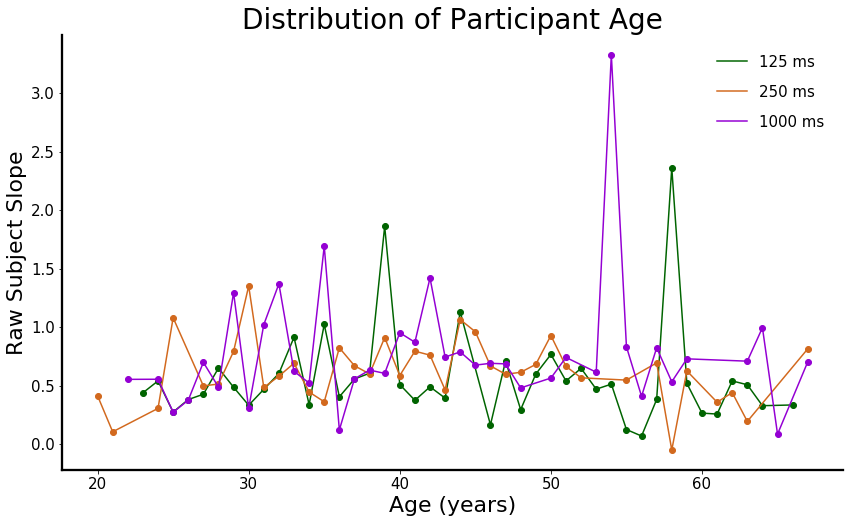

In [135]:
fig, ax = plt.subplots(figsize=[14,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Distribution of Participant Age', fontsize=28)
plt.ylabel('Raw Subject Slope', fontsize=22)
plt.xlabel('Age (years)', fontsize=22)


slope_125, intercept_125, r_value_125, p_value_125, std_err_125 = stats.linregress(df_age_125_mean.index, df_age_125_mean['raw_slope'])
# plt.plot(df_age_125_mean.index, df_age_125_mean['raw_slope'], label = '125 ms: m = ' + str(round(slope_125, 4)), color = "darkgreen")
plt.plot(df_age_125_mean.index, df_age_125_mean['raw_slope'], label = '125 ms', color = "darkgreen")


plt.plot(df_age_125_mean['raw_slope'], 'o', color = "darkgreen")

print(r_value_125 **2)

slope_250, intercept_250, r_value_250, p_value_250, std_err_250 = stats.linregress(df_age_250_mean.index, df_age_250_mean['raw_slope'])
# plt.plot(df_age_250_mean.index, df_age_250_mean['raw_slope'], label = '250 ms: m = ' + str(round(slope_250, 4)), color = "chocolate")
plt.plot(df_age_250_mean.index, df_age_250_mean['raw_slope'], label = '250 ms', color = "chocolate")


plt.plot(df_age_250_mean['raw_slope'], 'o', color = "chocolate")

print(r_value_250 **2)

slope_1000, intercept_1000, r_value_1000, p_value_1000, std_err_1000 = stats.linregress(df_age_1000_mean.index, df_age_1000_mean['raw_slope'])
# plt.plot(df_age_1000_mean.index, df_age_1000_mean['raw_slope'], label = '1000 ms: m = ' + str(round(slope_1000, 4)), color = "darkviolet")
plt.plot(df_age_1000_mean.index, df_age_1000_mean['raw_slope'], label = '1000 ms', color = "darkviolet")


plt.plot(df_age_1000_mean['raw_slope'], 'o', color = "darkviolet")

print(r_value_1000 **2)


# plt.axhline(y=1, color = 'black',linestyle='--', label = "Perfect Accuracy Slope")


legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.8, labelspacing = 1, frameon=False)


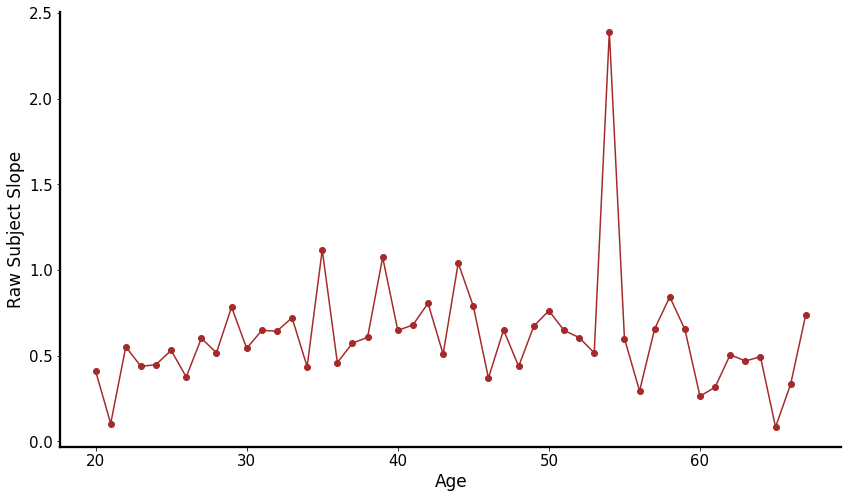

In [140]:
fig, ax = plt.subplots(figsize=[14,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xlabel("Age", fontsize = 17)
plt.ylabel("Raw Subject Slope", fontsize = 17)


slope, intercept, r_value, p_value, std_err = stats.linregress(df_age_mean.index, df_age_mean['raw_slope'])
plt.plot(df_age_mean.index, df_age_mean['raw_slope'], label = 'm = ' + str(round(slope, 4)), color = "brown")
# plt.plot(df_age_mean.index, df_age_mean['raw_slope'], color = "brown")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(df_age_mean['raw_slope'], 'o', color = "brown")

plt.show()

## Gender

In [141]:
final_data.gender.unique()
gender_dict_count = {}
for response in final_data.gender.unique():
    gender_dict_count[response] = 0

In [142]:
for subj in final_data.subjID.unique():
    subj_gender = final_data.loc[final_data['subjID']==subj].gender.unique()[0]
    gender_dict_count[subj_gender] += 1
    

In [144]:
gender_dict_count

# since there is not enough data in the gender conditions outside of 'Man' and 'Woman', we will not analyze that data in the gender analysis 

{'Man': 265,
 'Woman': 199,
 'Non-binary': 2,
 'trangender woman': 1,
 'Prefer not to answer': 1}

In [145]:
enough_samples_genders = ['Man', 'Woman']

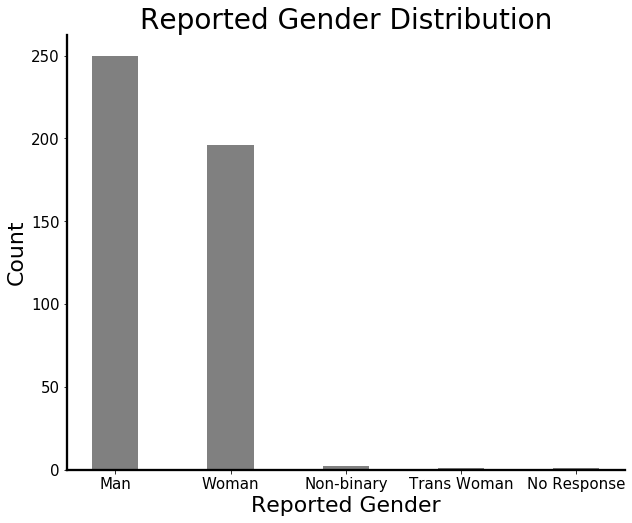

In [148]:


fig, ax = plt.subplots(figsize=[10,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


plt.title("Reported Gender Distribution", fontsize = 28)
plt.xlabel("Reported Gender", fontsize = 22)
plt.ylabel("Count", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)



plt.bar(['Man', 'Woman', 'Non-binary', 'Trans Woman', 'No Response'], [250, 196,2, 1, 1], color='gray', width=0.4)
plt.show();

### Extract participant reported gender, z-scored slope, and raw slope

In [149]:

subjID = []
gender = []
duration_cond = []
zs_slope = []
raw_slope = []

for subj in final_data.subjID.unique():
    subj_gender = final_data.loc[final_data['subjID']==subj].gender.unique()[0]
    if subj_gender in enough_samples_genders:
        subj_zs_slope = subject_summary.loc[subject_summary["subjID"]==subj].slope.unique()[0]
        subj_raw_slope = raw_subject_summary.loc[raw_subject_summary["subjID"]==subj].slope.unique()[0]
        subj_duration_cond = final_data.loc[final_data['subjID']==subj].duration.unique()[0]

        subjID.append(subj) 
        gender.append(subj_gender)
        duration_cond.append(subj_duration_cond)
        zs_slope.append(subj_zs_slope)
        raw_slope.append(subj_raw_slope)
#         print(subj, subj_gender, subj_duration_cond, subj_zs_slope, subj_raw_slope)

In [150]:
# Calling DataFrame constructor after zipping both lists, with columns specified
df_gender_analysis = pd.DataFrame(list(zip(subjID, gender, duration_cond, zs_slope, raw_slope)),
               columns =['subjID', 'gender', 'duration', 'zs_slope', 'raw_slope'])

In [151]:
df_gender_analysis

,subjID,gender,duration,zs_slope,raw_slope
0,541423,Man,125,0.741418,0.863528
1,104257,Woman,125,0.581617,0.314636
2,928935,Man,1000,0.558336,0.293113
3,596417,Man,1000,0.754673,1.051256
4,480789,Woman,1000,0.275887,0.037957
...,...,...,...,...,...
459,352815,Man,1000,0.748482,0.651701
460,394603,Man,1000,0.685278,0.803610
461,757697,Woman,1000,0.497181,0.275333
462,508587,Man,125,0.617442,0.356431


### Save gender x slope data

In [133]:
df_gender_analysis.to_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/gender_slopes.csv')

In [152]:
df_gender_125 = df_gender_analysis.loc[df_gender_analysis['duration']==125]
df_gender_250 = df_gender_analysis.loc[df_gender_analysis['duration']==250]
df_gender_1000 = df_gender_analysis.loc[df_gender_analysis['duration']==1000]

In [153]:
df_gender_125_mean = df_gender_125.groupby(['gender']).mean()
df_gender_250_mean = df_gender_250.groupby(['gender']).mean()
df_gender_1000_mean = df_gender_1000.groupby(['gender']).mean()

df_gender_125_sem = df_gender_125.groupby(['gender']).sem()
df_gender_250_sem = df_gender_250.groupby(['gender']).sem()
df_gender_1000_sem = df_gender_1000.groupby(['gender']).sem()

In [154]:
df_gender_125_mean['zs_slope'], df_gender_125_sem['zs_slope']

(gender
 Man      0.512547
 Woman    0.459943
 Name: zs_slope, dtype: float64, gender
 Man      0.021506
 Woman    0.024305
 Name: zs_slope, dtype: float64)

In [155]:
df_gender_mean = df_gender_analysis.groupby(['gender']).mean()

df_gender_mean_sem = df_gender_analysis.groupby(['gender']).sem()

<!-- 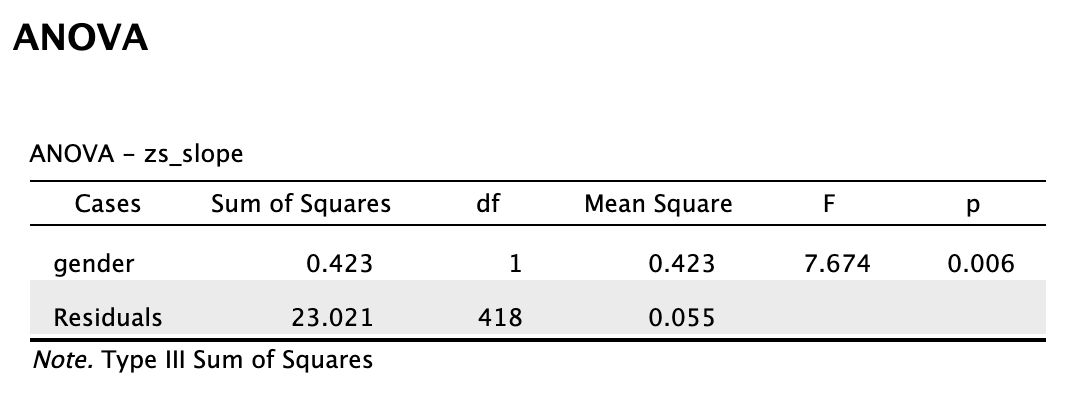 -->

In [156]:
man_125_zs = list(df_gender_125.loc[df_gender_125['gender']=='Man']['zs_slope'])
woman_125_zs = list(df_gender_125.loc[df_gender_125['gender']=='Woman']['zs_slope'])

man_250_zs = list(df_gender_250.loc[df_gender_250['gender']=='Man']['zs_slope'])
woman_250_zs = list(df_gender_250.loc[df_gender_250['gender']=='Woman']['zs_slope'])

man_1000_zs = list(df_gender_1000.loc[df_gender_1000['gender']=='Man']['zs_slope'])
woman_1000_zs = list(df_gender_1000.loc[df_gender_1000['gender']=='Woman']['zs_slope'])


all_men_slopes = man_125_zs + man_250_zs + man_1000_zs

all_women_slopes = woman_125_zs + woman_250_zs + woman_1000_zs

In [157]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_men_slopes, all_women_slopes)
print('Men Slopes vs Women Slopes')
print(fvalue, pvalue)

print()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(man_125_zs, woman_125_zs)
print('125 ms: Men vs Women')
print(fvalue, pvalue)
print()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(man_250_zs, woman_250_zs)
print('250 ms: Men vs Women')
print(fvalue, pvalue)
print()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(man_1000_zs, woman_1000_zs)
print('1000 ms: Men vs Women')
print(fvalue, pvalue)


Men Slopes vs Women Slopes
7.158968769061112 0.007723917009844416

125 ms: Men vs Women
2.6398258107867996 0.10630047348248935

250 ms: Men vs Women
2.710175905628112 0.101749274840947

1000 ms: Men vs Women
1.8589540135720701 0.17474842541177732


In [158]:
df_gender_125_mean

,subjID,duration,zs_slope,raw_slope
gender,,,,
Man,524795.869048,125.0,0.512547,0.552292
Woman,509797.739130,125.0,0.459943,0.612748


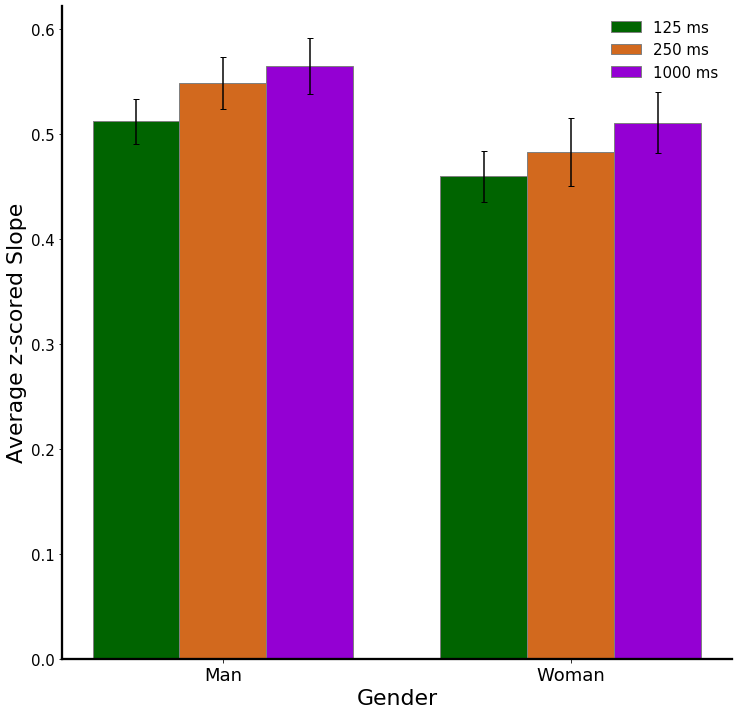

In [161]:
# set width of bar
barWidth = 0.25

fig, ax = plt.subplots(figsize=[12,12])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

# set height of bar
ms125 = df_gender_125_mean['zs_slope']
ms250 = df_gender_250_mean['zs_slope']
ms1000 = df_gender_1000_mean['zs_slope']
 
# Set position of bar on X axis
br1 = np.arange(len(ms125))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, ms125, color ='darkgreen', width = barWidth,
        edgecolor ='grey', label ='125 ms', yerr=df_gender_125_sem['zs_slope'], capsize=3)
plt.bar(br2, ms250, color ='chocolate', width = barWidth,
        edgecolor ='grey', label ='250 ms', yerr=df_gender_250_sem['zs_slope'], capsize=3)
plt.bar(br3, ms1000, color ='darkviolet', width = barWidth,
        edgecolor ='grey', label ='1000 ms', yerr=df_gender_1000_sem['zs_slope'], capsize=3)
 
# Adding Xticks
plt.xlabel('Gender', fontsize = 22)
plt.ylabel('Average z-scored Slope', fontsize = 22)
plt.xticks([r + barWidth for r in range(2)],
        ['Man', 'Woman'], fontsize=18)
plt.yticks(fontsize=15)
 
plt.legend(fontsize=15, frameon=False)
plt.show()

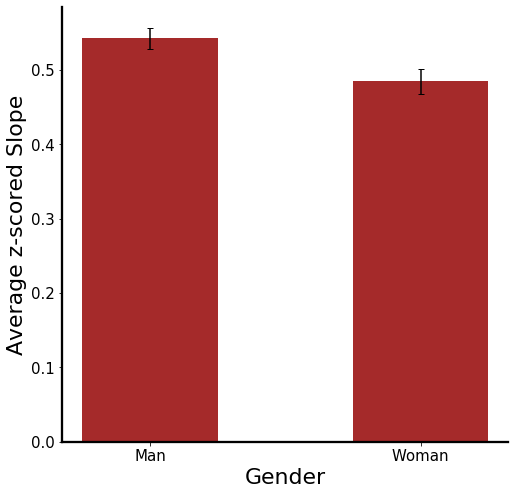

In [162]:
# Figure Size

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
barWidth = 0.5

 
# Horizontal Bar Plot
plt.bar(['Man', 'Woman'], df_gender_mean['zs_slope'], color='brown', yerr = df_gender_mean_sem['zs_slope'], capsize=3, width=barWidth)

plt.xticks(['Man', 'Woman'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gender', fontsize = 22)
plt.ylabel('Average z-scored Slope',  fontsize = 22)
 
# Show Plot
plt.show()

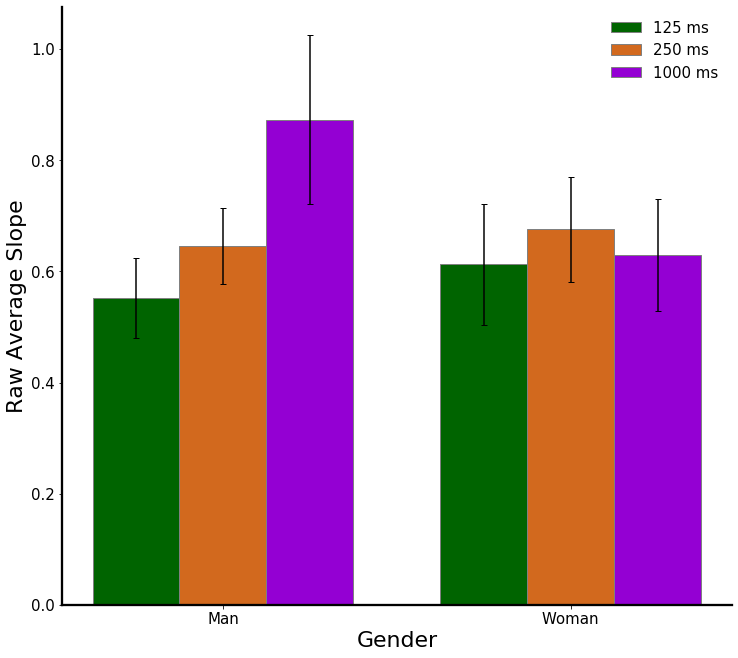

In [163]:
# set width of bar
barWidth = 0.25

fig, ax = plt.subplots(figsize=[12,11])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3) 
# set height of bar
ms125 = df_gender_125_mean['raw_slope']
ms250 = df_gender_250_mean['raw_slope']
ms1000 = df_gender_1000_mean['raw_slope']
 
# Set position of bar on X axis
br1 = np.arange(len(ms125))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, ms125, color ='darkgreen', width = barWidth,
        edgecolor ='grey', label ='125 ms', yerr=df_gender_125_sem['raw_slope'], capsize=3)
plt.bar(br2, ms250, color ='chocolate', width = barWidth,
        edgecolor ='grey', label ='250 ms', yerr=df_gender_250_sem['raw_slope'], capsize=3)
plt.bar(br3, ms1000, color ='darkviolet', width = barWidth,
        edgecolor ='grey', label ='1000 ms', yerr=df_gender_1000_sem['raw_slope'], capsize=3)
 
# Adding Xticks
plt.xlabel('Gender', fontsize = 22)
plt.ylabel('Raw Average Slope', fontsize = 22)
plt.xticks([r + barWidth for r in range(2)],
        ['Man', 'Woman'], fontsize=15)
plt.yticks(fontsize=15)
 
plt.legend(fontsize=15, frameon=False)
plt.show()

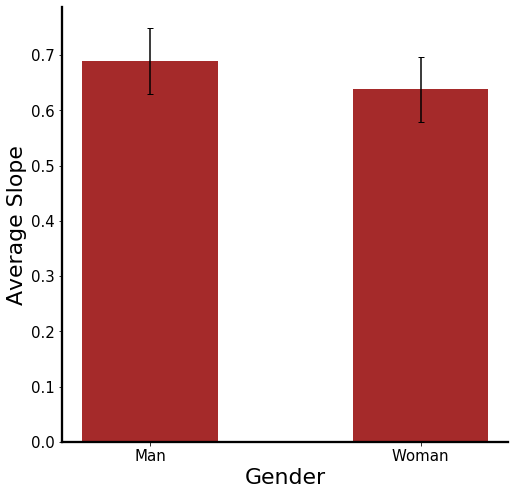

In [164]:
# Figure Size

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
barWidth = 0.5

 
# Horizontal Bar Plot
plt.bar(['Man', 'Woman'], df_gender_mean['raw_slope'], color='brown', yerr = df_gender_mean_sem['raw_slope'], capsize=3, width=barWidth)

plt.xticks(['Man', 'Woman'], fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Gender',  fontsize = 22)
plt.ylabel('Average Slope',  fontsize = 22)
 
# Show Plot
plt.show()

## Screen size analysis

Unit = pixels

In [168]:
screenWidths = np.array(final_data['screenWidth'])
screenHeights = np.array(final_data['screenHeight'])

In [169]:
np.mean(screenWidths), np.std(screenWidths)

(1589.1608277568464, 385.2954157736873)

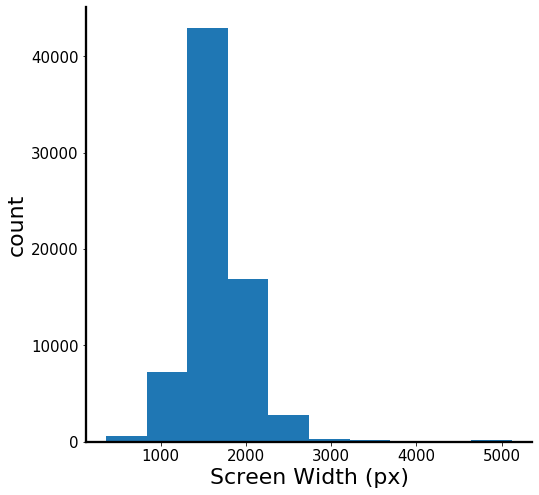

In [174]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Screen Width (px)',  fontsize = 22)
plt.ylabel('count',  fontsize = 22)
    
plt.hist(screenWidths)
plt.show();

In [46]:
np.mean(screenHeights), np.std(screenHeights)

(907.8756115391104, 177.45941198901753)

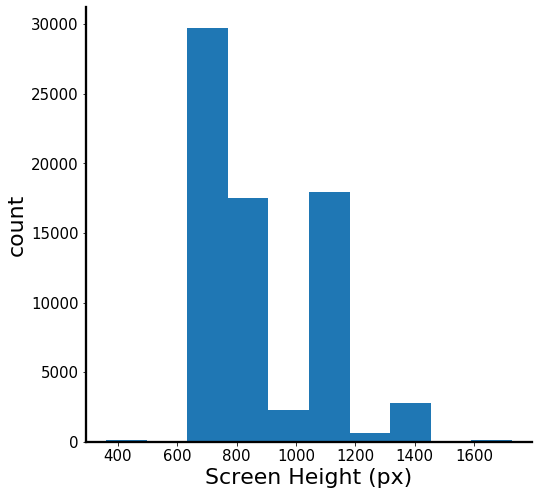

In [175]:
fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Screen Height (px)',  fontsize = 22)
plt.ylabel('count',  fontsize = 22)

plt.hist(screenHeights)
plt.show();

# Time

In [177]:
# time in minutes
(np.array(final_data['totalTime'])//1000)/60

array([11.26666667, 11.26666667, 11.26666667, ..., 19.1       ,
       19.1       , 19.1       ])

In [178]:
# average time spent, std of time spent
np.mean((np.array(final_data['totalTime'])//1000)/60), np.std((np.array(final_data['totalTime'])//1000)/60)

(18.08423306903597, 6.875577611083948)